# Load LLM, SAEs

sae layers: [7, 14, 21, 40]
llm gemma 9b

In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer
import torch
import circuitsvis as cv
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, FactoredMatrix
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import math
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import functools
import pandas as pd
from pprint import pprint as pp
from typing import Tuple
from torch import Tensor
from functools import lru_cache
from torch import tensor
from typing import TypedDict, Optional, Tuple, Union
from tqdm import tqdm
import signal

from sae_lens import SAE, HookedSAETransformer
import transformer_lens
import json
import random
import wandb

# Load a model
model = transformer_lens.HookedTransformer.from_pretrained("gemma-2-9b", device="cuda")
pad_token_id = model.tokenizer.pad_token_id
print('pad token id is', pad_token_id)

for param in model.parameters():
   param.requires_grad_(False)

device = "cuda"



/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Loaded pretrained model gemma-2-9b into HookedTransformer
pad token id is 0


In [2]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)
assert device == 'cuda', "This notebook is not optimized for CPU"


In [3]:
layers= [7, 14, 21, 40]
l0s = [92, 67, 129, 125]
saes = [SAE.from_pretrained(release="gemma-scope-9b-pt-res", sae_id=f"layer_{layers[i]}/width_16k/average_l0_{l0s[i]}", device=device)[0] for i in range(len(layers))]

# Load Dataset

In [4]:
@lru_cache(maxsize=None)
def memoize_encode(text):
    return(model.to_tokens(text))

In [1]:
# Expanding the name pool with a larger set of names
extended_name_pool = [
    "Bob", "Sam", "Lilly", "Rob", "Alice", "Charlie", "Sally", "Tom", "Jake", "Emily", 
    "Megan", "Chris", "Sophia", "James", "Oliver", "Isabella", "Mia", "Jackson", 
    "Emma", "Ava", "Lucas", "Benjamin", "Ethan", "Grace", "Olivia", "Liam", "Noah", "Diego"
]
for name in extended_name_pool:
    assert len(model.tokenizer.encode(name)) == 2, f"Name {name} has more than 1 token"
# Function to generate the dataset with correct and incorrect keying into dictionaries
def generate_extended_dataset(name_pool, num_samples=5):
    dataset = []
    for _ in range(num_samples):
        # Randomly select 5 names from the pool
        selected_names = random.sample(name_pool, 5)
        # Assign random ages to the selected names
        age_dict = {name: random.randint(10, 19) for name in selected_names}
        # Create a correct example
        correct_name = random.choice(list(age_dict.keys()))
        correct_prompt = f'Type "help", "copyright", "credits" or "license" for more information.\n>>> age = {age_dict}\n>>> age["{correct_name}"]\n'
        correct_response = age_dict[correct_name]
        correct_token = str(correct_response)[0]
        # Create an incorrect example with a name not in the dictionary
        
        incorrect_name = random.choice([name for name in name_pool if name not in age_dict])
        if random.random()>0.5:
            # put the new name in the key.
            incorrect_prompt = f'Type "help", "copyright", "credits" or "license" for more information.\n>>> age = {age_dict}\n>>> age["{incorrect_name}"]\n'
        else:
            # put the new name in the dict, and swap the key.
            keys = list(age_dict.keys())
            items = list(age_dict.values())

            location = keys.index(correct_name)
            keys[location] = incorrect_name

            
            broken_age_dict = dict(zip(keys, items))
            incorrect_prompt = f'Type "help", "copyright", "credits" or "license" for more information.\n>>> age = {broken_age_dict}\n>>> age["{correct_name}"]\n'
            
            
            


        incorrect_response = "Traceback"
        incorrect_token = "Traceback"

        # Append the pair of correct and incorrect examples
        dataset.append({
            "correct": {
                "prompt": correct_prompt,
                "response": correct_response,
                "token": correct_token
            },
            "error": {
                "prompt": incorrect_prompt,
                "response": incorrect_response,
                "token": incorrect_token
            }
        })
    return dataset
# Generate the extended dataset
json_dataset = generate_extended_dataset(extended_name_pool, num_samples=100_000)

NameError: name 'model' is not defined

In [6]:
simple_dataset_ex_len = 65

In [7]:
def response_to_token(response):
    return memoize_encode(str(response)).squeeze()[1]

class ContrastiveDatasetBatch:
    def __init__(self, dataset_items):
        self.correct_batch = [item["correct"] for item in dataset_items]
        self.error_batch = [item["error"] for item in dataset_items]
        self.batch_size = len(self.correct_batch)
        self.correct_token_idx = model.to_single_token("1")
        self.error_token_idx = model.to_single_token("Traceback")

        correct_tokenized = None
        error_tokenized = None

        correct_prompts = [example["prompt"] for example in self.correct_batch]
        error_prompts = [example["prompt"] for example in self.error_batch]

        correct_answers = torch.tensor([response_to_token(example['response']) for example in self.correct_batch], dtype=torch.int64)
        error_answers = torch.tensor([response_to_token(example['response']) for example in self.error_batch], dtype=torch.int64)

        assert len(correct_prompts) == len(error_prompts)
        all_prompts = correct_prompts + error_prompts
        all_tokenized = model.to_tokens(all_prompts)
        last_non_pad_idxs = torch.count_nonzero(all_tokenized != pad_token_id, dim=-1) - 1


        correct_tokenized = all_tokenized[:self.batch_size]
        correct_answer_idxs = last_non_pad_idxs[:self.batch_size]
        error_tokenized = all_tokenized[self.batch_size:]
        error_answer_idxs = last_non_pad_idxs[self.batch_size:]

        self.correct_tokenized = correct_tokenized
        self.error_tokenized = error_tokenized
        self.correct_answer_seq_idxs = correct_answer_idxs
        self.error_answer_seq_idxs = error_answer_idxs
        self.correct_labels = correct_answers
        self.error_labels = error_answers

        self.all_tokenized = all_tokenized
        self.all_answer_seq_idxs = last_non_pad_idxs
        self.all_prompts = all_prompts
        # the tokens are: [correct prompt, correct prompt, ..., error prompt, error prompt, ...]
        self.all_answers_tok_idxs = torch.cat(
            [
                torch.ones(self.batch_size, dtype=torch.int64)*self.correct_token_idx,
                torch.ones(self.batch_size, dtype=torch.int64)*self.error_token_idx
            ]
            )
        self.all_wrong_answers_tok_idxs = torch.cat(
            [
                torch.ones(self.batch_size, dtype=torch.int64)*self.error_token_idx,
                torch.ones(self.batch_size, dtype=torch.int64)*self.correct_token_idx
            ]
            )
        self.all_answers_correct_labels = torch.cat([self.correct_labels, self.error_labels])




eval_dataset = ContrastiveDatasetBatch(json_dataset[:10])

In [8]:
simple_dataset = []
simple_labels = []

# answer_token = model.to_single_token("1")
# traceback_token = model.to_single_token("Traceback")

for item in json_dataset:
    simple_dataset.append(item["correct"]["prompt"])
    simple_dataset.append(item["error"]["prompt"])
    simple_labels.append(response_to_token(item["correct"]["response"]))
    simple_labels.append(response_to_token(item["error"]["response"]))


simple_dataset = model.to_tokens(simple_dataset)
simple_labels = torch.tensor(simple_labels)



In [9]:
permutation = torch.randperm(len(simple_dataset))
simple_dataset = simple_dataset[permutation]
simple_labels = simple_labels[permutation]

# Helper Fns

In [10]:
def clear_memory():
    for sae in saes:
        for param in sae.parameters():
            param.grad = None
        for param in sae.mask.parameters():
            param.grad = None
    for param in model.parameters():
        param.grad = None
    torch.cuda.empty_cache()


In [11]:
class KeyboardInterruptBlocker:
    def __enter__(self):
        # Block SIGINT and store old mask
        self.old_mask = signal.pthread_sigmask(signal.SIG_BLOCK, {signal.SIGINT})

    def __exit__(self, exc_type, exc_value, traceback):
        # Restore old mask (unblock SIGINT)
        signal.pthread_sigmask(signal.SIG_SETMASK, self.old_mask)

class Range:
    def __init__(self, *args):
        # Support for range(start, stop, step) or range(stop)
        self.args = args

        # Validate input like the built-in range does
        if len(self.args) not in {1, 2, 3}:
            raise TypeError(f"Range expected at most 3 arguments, got {len(self.args)}")
        
        self.range = __builtins__.range(*self.args)  # Create the range object

    def __iter__(self):
        for i in self.range:
            try:
                with KeyboardInterruptBlocker():
                    yield i
            except KeyboardInterrupt:
                print("Keyboard interrupt received. Exiting iteration.")
                break

    def __len__(self):
        return len(self.range)


## Mask Types

In [12]:
class SparseMask(nn.Module):
    def __init__(self, shape, l1, seq_len=None, distinct_l1=0):
        super().__init__()
        if seq_len is not None:
            self.mask = nn.Parameter(torch.ones(seq_len, shape))
        else:
            self.mask = nn.Parameter(torch.ones(shape))
        self.l1 = l1
        self.distinct_l1 = distinct_l1
        self.max_temp = torch.tensor(1000.0)
        self.sparsity_loss = None
        self.ratio_trained = 1
        self.temperature = 1
        self.distinct_sparsity_loss = 0


    def forward(self, x, binary=False, mean_ablation=None):
        if binary:
            # binary mask, 0 if negative, 1 if positive
            binarized = (self.mask > 0).float()
            if mean_ablation is None:
                return x * binarized
            else:
                diff = x - mean_ablation
                return diff * binarized + mean_ablation
            

        self.temperature = self.max_temp ** self.ratio_trained
        mask = torch.sigmoid(self.mask * self.temperature)
        self.sparsity_loss = torch.abs(mask).sum() * self.distinct_l1
        if len(mask.shape) == 2:
            self.distinct_sparsity_loss = torch.abs(mask).max(dim=0).values.sum() * self.l1

        if mean_ablation is None:
            return x * mask
        else:
            diff = x - mean_ablation
            return diff * mask + mean_ablation



for sae in saes:
    sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=65)
# saes[0].mask = SparseMask(saes[0].cfg.d_sae, 1.0)
# saes[1].mask = SparseMask(saes[1].cfg.d_sae, 1.0)



In [ ]:
tensor([1,2,3,4])

In [202]:
class IGMask(nn.Module):
    # igscores is seq x num_sae_latents
    def __init__(self, ig_scores):
        super().__init__()
        self.ig_scores = ig_scores

    def forward(self, x, threshold, mean_ablation = None):
        censored_activations = torch.ones_like(x)
        if mean_ablation != None:
            censored_activations = censored_activations * mean_ablation
        else:
            censored_activations = censored_activations * 0

        mask = (self.ig_scores.abs() > threshold).float()
        
        diff_to_x = x - censored_activations
        return censored_activations + diff_to_x * mask
    
    def get_threshold_info(self, threshold):
        mask = (self.ig_scores.abs() > threshold).float()

        total_latents = mask.sum()
        avg_latents_per_tok = mask.sum()/mask.shape[0]
        latents_per_tok = mask.sum(dim=-1)
        return {"total_latents":total_latents,
                "avg_latents_per_tok":avg_latents_per_tok,
                "latents_per_tok":latents_per_tok}

def refresh_class():
    for sae in saes:
        if hasattr(sae, 'igmask'):
            sae.igmask = IGMask(sae.igmask.ig_scores)

try:
    refresh_class()
except Exception as e:
    print(e)

refresh_class()



In [14]:
def apply_mask(mask_idxs, sae):
    mask = torch.full_like(sae.mask.mask, -10)
    mask[mask_idxs] = 10
    sae.mask.mask.data = mask

In [15]:
def load_sparsemask(mask_path):
    json_mask = json.load(open(mask_path))
    for sae in saes:
        apply_mask(json_mask[sae.cfg.hook_name], sae)
    

## Build Hook

In [143]:
bos_token_id = model.tokenizer.bos_token_id

def build_sae_hook_fn(
    # Core components
    sae,
    sequence,
    
    # Masking options
    circuit_mask=None,
    use_mask=False,
    binarize_mask=False,
    mean_mask=False,
    ig_mask_threshold=None,
    
    # Caching behavior
    cache_sae_grads=False,
    cache_masked_activations=False,
    cache_sae_activations=False,
    
    # Ablation options
    mean_ablate=False,  # Controls mean ablation of the SAE
    fake_activations=False,  # Controls whether to use fake activations
    ):    # make the mask for the sequence
    mask = torch.ones_like(sequence, dtype=torch.bool)
    # mask[sequence == pad_token_id] = False
    mask[sequence == bos_token_id] = False # where mask is false, keep original
    def sae_hook(value, hook):
        # print(f"sae {sae.cfg.hook_name} running at layer {hook.layer()}")
        feature_acts = sae.encode(value)
        feature_acts = feature_acts * mask.unsqueeze(-1)
        if fake_activations != False and sae.cfg.hook_layer == fake_activations[0]:
            feature_acts = fake_activations[1]
        if cache_sae_grads:
            raise NotImplementedError("torch is confusing")
            sae.feature_acts = feature_acts.requires_grad_(True)
            sae.feature_acts.retain_grad()
        
        if cache_sae_activations:
            sae.feature_acts = feature_acts.detach().clone()
        
        
        
        # Learned Binary Masking
        if use_mask:
            if mean_mask:
                # apply the mask, with mean ablations
                feature_acts = sae.mask(feature_acts, binary=binarize_mask, mean_ablation=sae.mean_ablation)
            else:
                # apply the mask, without mean ablations
                feature_acts = sae.mask(feature_acts, binary=binarize_mask)

        # IG Masking
        if ig_mask_threshold != None:
            # apply the ig mask
            if mean_mask:
                feature_acts = sae.igmask(feature_acts, threshold=ig_mask_threshold, mean_ablation=sae.mean_ablation)
            else:
                feature_acts = sae.igmask(feature_acts, threshold=ig_mask_threshold)

                
        

        

        if circuit_mask is not None:
            raise NotImplementedError("mask interface not supported")
            mask_method = circuit_mask['mask_method']
            mask_indices = circuit_mask[sae.cfg.hook_name]
            if mask_method == 'keep_only':
                # any activations not in the mask are set to 0
                expanded_circuit_mask = torch.zeros_like(feature_acts)
                expanded_circuit_mask[:, :, mask_indices] = 1
                feature_acts = feature_acts * expanded_circuit_mask
            elif mask_method == 'zero_only':
                feature_acts[:, :, mask_indices] = 0
            else:
                raise ValueError(f"mask_method {mask_method} not recognized")
            
        if cache_masked_activations:
            sae.feature_acts = feature_acts.detach().clone()
        if mean_ablate:
            feature_acts = sae.mean_ablation

        out = sae.decode(feature_acts)
        # choose out or value based on the mask
        mask_expanded = mask.unsqueeze(-1).expand_as(value)
        value = torch.where(mask_expanded, out, value)
        return value
    return sae_hook


    # def sae_hook_ablate(value, hook):
    # feature_acts = sae.encode(value)
    # # feature_acts[:, :, topsae_attr_indices] = 0
    # out = sae.decode(feature_acts)
    # return out


def build_hooks_list(sequence,
                    cache_sae_activations=False,
                    cache_sae_grads=False,
                    circuit_mask=None,
                    use_mask=False,
                    binarize_mask=False,
                    mean_mask=False,
                    cache_masked_activations=False,
                    mean_ablate=False,
                    fake_activations: Tuple[int, torch.Tensor] = False,
                    ig_mask_threshold=None,
                    ):
    hooks = []
    # blocks.0.hook_resid_pre
    # # fake hook that adds zero so gradients propagate through the model
    # param = nn.Parameter(torch.tensor(0.0, requires_grad=True))
    # hooks.append(
    #     (
    #         "blocks.0.hook_resid_pre",
    #         lambda value, hook: value + param,
    #     )
    # )
    for sae in saes:
        hooks.append(
            (
            sae.cfg.hook_name,
            build_sae_hook_fn(sae, sequence, cache_sae_grads=cache_sae_grads, circuit_mask=circuit_mask, use_mask=use_mask, binarize_mask=binarize_mask, cache_masked_activations=cache_masked_activations, cache_sae_activations=cache_sae_activations, mean_mask=mean_mask, mean_ablate=mean_ablate, fake_activations=fake_activations, ig_mask_threshold=ig_mask_threshold),
            )
        )
    return hooks 

def build_sae_logitfn(**kwargs):
    def logitfn(tokens):
        return model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens, **kwargs)
            )
    return logitfn

In [17]:
vocab = simple_labels.view(-1).unique()

def get_highest_other_logit(logits, label):
    other_logits = logits.clone()
    # set the logits for the correct label to -infinity
    other_logits[..., label] = -float("inf")
    # get the highest logit for the other labels
    mask = torch.ones_like(other_logits) * -float("inf")
    mask[..., vocab] = 0
    other_logits = other_logits + mask

    return other_logits.max(dim=-1).values

def get_highest_other_prob(logits, label):
    other_logits = logits.clone()
    # set the logits for the correct label to -infinity
    other_logits[..., label] = 0
    # get the highest logit for the other labels
    #mask = torch.ones_like(other_logits) * 0
    #mask[..., vocab] = 0
    #other_logits = other_logits + mask

    return other_logits.max(dim=-1).values


In [267]:
def compute_token_probabilities(logits, seq_idxs, labels):
    """Compute probabilities, logit differences, and CE loss for token predictions."""
    # Get probabilities for all tokens at the sequence positions
    probs = F.softmax(logits[torch.arange(logits.shape[0]), seq_idxs], dim=-1)
    
    # Calculate mean probabilities for correct and error tokens
    prob_correct = probs[torch.arange(probs.shape[0]), labels].mean().item()
    max_prob_idxs = probs.argmax(dim=-1)
    top1_acc = (max_prob_idxs == labels).float().mean().item()
    prob_error = get_highest_other_prob(probs, labels).mean().item()
    
    # Calculate logit difference
    correct_logits = logits[torch.arange(logits.shape[0]), seq_idxs, labels]
    error_logits = get_highest_other_logit(logits[torch.arange(logits.shape[0]), seq_idxs], labels)
    logit_diff = (correct_logits - error_logits).mean().item()
    
    # Calculate CE loss
    ce_loss = F.cross_entropy(
        logits[torch.arange(logits.shape[0]), seq_idxs], 
        labels
    ).item()
    
    return prob_correct, prob_error, logit_diff, top1_acc, ce_loss

def sanity_check_model_performance(logitfn):
    """Run sanity checks on model performance using contrastive examples."""
    baseline_dataset = ContrastiveDatasetBatch(json_dataset[-10:])
    
    # Get logits for both correct and error examples
    correct_logits = logitfn(baseline_dataset.correct_tokenized)
    error_logits = logitfn(baseline_dataset.error_tokenized)
    
    # Analyze correct examples
    prob_correct_in_correct, prob_error_in_correct, logit_diff_correct, top1_correct, ce_loss_correct = compute_token_probabilities(
        correct_logits,
        baseline_dataset.correct_answer_seq_idxs,
        baseline_dataset.correct_labels,
    )
    
    # Analyze error examples
    prob_error_in_error, prob_correct_in_error, logit_diff_error, top1_error, ce_loss_error = compute_token_probabilities(
        error_logits,
        baseline_dataset.error_answer_seq_idxs,
        baseline_dataset.error_labels,
    )
    
    return {
        'prob_age_given_correct': prob_correct_in_correct,
        'prob_traceback_given_correct(bad)': prob_error_in_correct,
        'logit_diff_correct(-=bad)': logit_diff_correct,
        'top1_correct': top1_correct,
        'ce_loss_correct': ce_loss_correct,
        'prob_traceback_given_error': prob_error_in_error,
        'prob_age_given_error(bad)': prob_correct_in_error,
        'logit_diff_error(-=bad)': logit_diff_error,
        'top1_error': top1_error,
        'ce_loss_error': ce_loss_error
    }

In [20]:
# def all_contrastive_difference(logitfn):
#     baseline_dataset = ContrastiveDatasetBatch(json_dataset[0:10])
#     all_tokenized = baseline_dataset.all_tokenized
#     all_answer_seq_idxs = baseline_dataset.all_answer_seq_idxs
#     all_answers_tok_idxs = baseline_dataset.all_answers_tok_idxs
#     all_wrong_answers_tok_idxs = baseline_dataset.all_wrong_answers_tok_idxs
#     all_prompts = baseline_dataset.all_prompts
    
#     all_logits = logitfn(all_tokenized)
#     all_answer_logits = all_logits[torch.arange(all_logits.shape[0]), all_answer_seq_idxs]
#     all_answers_correct_logits = all_answer_logits[torch.arange(all_answer_logits.shape[0]), all_answers_tok_idxs]
#     all_answers_wrong_logits = all_answer_logits[torch.arange(all_answer_logits.shape[0]), all_wrong_answers_tok_idxs]
#     all_logit_diffs = all_answers_correct_logits - all_answers_wrong_logits
#     # 6.7 dif for correct, 1.8 for error
#     all_logit_diffs[0:baseline_dataset.batch_size] = all_logit_diffs[0:baseline_dataset.batch_size]/6.7
#     all_logit_diffs[baseline_dataset.batch_size:] = all_logit_diffs[baseline_dataset.batch_size:]/1.8
#     return all_logit_diffs



# SAE vs no SAE (sanity check and basic setup)

In [21]:
baseline_dataset = ContrastiveDatasetBatch(json_dataset[10:15])

In [22]:
def baseline_model_logit_fn(tokens):
    correct_logits = model.run_with_hooks(
        tokens, 
        return_type="logits", 
        fwd_hooks=[
            #(
            #utils.get_act_name("pre", 0), # v=attention out
            #"blocks.0.hook_mlp_out",
            #mlp_ablation_hook,
            #),
            ]
        )
    return correct_logits

with torch.no_grad():
    pp(sanity_check_model_performance(baseline_model_logit_fn))

{'logit_diff_correct': 6.455362796783447,
 'logit_diff_error': 7.130212306976318,
 'prob_correct_in_correct': 0.9796140789985657,
 'prob_correct_in_error': 0.010493866167962551,
 'prob_error_in_correct': 0.006548810750246048,
 'prob_error_in_error': 0.9655432105064392,
 'top1_correct': 1.0,
 'top1_error': 1.0}


In [23]:
pad_token_id
bos_token_id = model.tokenizer.bos_token_id
bos_token_id

2

In [24]:
with torch.no_grad():
    def logitfn(tokens):
        return model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens)
            )
    pp(sanity_check_model_performance(logitfn))

{'logit_diff_correct': 6.603562355041504,
 'logit_diff_error': 2.0407333374023438,
 'prob_correct_in_correct': 0.9281081557273865,
 'prob_correct_in_error': 0.21055828034877777,
 'prob_error_in_correct': 0.027228400111198425,
 'prob_error_in_error': 0.19130192697048187,
 'top1_correct': 1.0,
 'top1_error': 0.30000001192092896}


In [25]:
with torch.no_grad():
    def logitfn(tokens):
        return model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens)
            )
    logits = logitfn(baseline_dataset.error_tokenized)

In [26]:
test_idx = 4
topk = torch.topk(logits[:, -1, :][test_idx], k=3)
print(model.to_str_tokens(topk.indices))
print(topk.values)
logits[:, -1, :][test_idx][baseline_dataset.correct_token_idx]

['>>>', 'Traceback', "{'"]
tensor([25.6073, 25.4474, 24.2372], device='cuda:0')


tensor(22.9575, device='cuda:0')

# Attribution

In [27]:
# def logitfn(tokens):
#     return model.run_with_hooks(
#         tokens, 
#         return_type="logits", 
#         fwd_hooks=build_hooks_list(tokens, cache_sae_grads=True)
#         )

# all_logit_diffs = all_contrastive_difference(logitfn)

In [28]:
# loss = all_logit_diffs.sum() * -1 # maximize the difference

In [29]:
# loss.backward()

In [30]:
# no_ablate = {"mask_method": "keep_only"}

In [31]:
# num_features = saes[0].cfg.d_sae

In [32]:
# with torch.no_grad():
#     for sae in saes:
#         delta_loss = torch.abs((sae.feature_acts.grad * sae.feature_acts).view(-1, sae.feature_acts.shape[-1]).sum(dim=0))
#         topk = torch.topk(delta_loss, k=63)
#         no_ablate[sae.cfg.hook_name] = topk.indices

In [33]:
# import random
# # deep copy
# import copy
# random_ablate = copy.deepcopy(no_ablate)

# num_features = saes[0].cfg.d_sae

# for key in random_ablate.keys():
#     if key == "mask_method":
#         continue
# #     for i in range(len(random_ablate[key])):
# #         random_ablate[key][i] = random.randint(0, num_features-1)
# # random_ablate

In [34]:
# # test the ablation
    
# with torch.no_grad():
#     def logitfn(tokens):
#         return model.run_with_hooks(
#             tokens, 
#             return_type="logits", 
#             fwd_hooks=build_hooks_list(
#                 tokens,
#                 cache_sae_grads=False,
#                 circuit_mask=no_ablate)
#             )
    
#     all_logit_diffs = sanity_check_model_performance(logitfn)
#     #all_logit_diffs = san(logitfn).mean()
#     # print(all_logit_diffs)

# Collect SAE Means

In [ ]:
# for each SAE create a sae_dim float32 with mean latent activation over subset of datset
batch_size = 16
zd
num_features = saes[0].cfg.d_sae

def logitfn(tokens):
    return model.run_with_hooks(
        tokens, 
        return_type="logits", 
        fwd_hooks=build_hooks_list(tokens, cache_sae_activations=True)
        )

def running_mean_tensor(old_mean, new_value, n):
    return old_mean + (new_value - old_mean) / n

# # test running mean tensor
# test_data = torch.arange(3).float()
# test_data

# data_examples = []
# for i in range(30):
#     # add noise to the data
#     data_examples.append(test_data + torch.randn_like(test_data)*0.1)

# running_mean = torch.zeros_like(test_data)
# for i, data in enumerate(data_examples):
#     running_mean = running_mean_tensor(running_mean, data, i+1)
#     print(running_mean)

# tok1 = traceback_token
# tok2 = answer_token


all_fwd_passes = []
def get_sae_means(total_steps, per_token_mask=False, keep_only='none'):
    all_optimized_params = []
    for sae in saes:
        sae.mean_ablation = torch.zeros(sae.cfg.d_sae).float()
    
    with tqdm(total=total_steps, desc="Mean Accum Progress") as pbar:
        for i, (x, y) in enumerate(zip(simple_dataset.view(-1, 65), simple_labels.view(-1))):
            # if keep_only == 'traceback' and y != traceback_token:
            #     continue
            # if keep_only == 'correct' and y != answer_token:
            #     continue

            with torch.no_grad():
                logits = logitfn(x)
                for sae in saes:
                    sae.mean_ablation = running_mean_tensor(sae.mean_ablation, sae.feature_acts, i+1)
            pbar.update(1)

            if i >= total_steps:
                break

get_sae_means(50, keep_only='none')


# # this won't work anymore b/c I removed mean_ablate
# def mean_ablated_logitfn(tokens):
#     return model.run_with_hooks(
#         tokens, 
#         return_type="logits", 
#         fwd_hooks=build_hooks_list(tokens, mean_ablate=True)
#         )

# # all_contrastive_difference
# sanity_check_model_performance(mean_ablated_logitfn)

# NOTE: If you run the rest of the code it adds a batch dim to this data, and this code is screwed
def mean_ablated_logitfn(tokens):
    return model.run_with_hooks(
        tokens, 
        return_type="logits", 
        fwd_hooks=build_hooks_list(tokens, mean_ablate=True)
        )

# all_contrastive_difference
sanity_check_model_performance(mean_ablated_logitfn)

Mean Accum Progress: 51it [00:06,  7.52it/s]                        


{'prob_age_given_correct': 0.6938444375991821,
 'prob_traceback_given_correct(bad)': 0.10545587539672852,
 'logit_diff_correct(-=bad)': 3.1603641510009766,
 'top1_correct': 1.0,
 'prob_traceback_given_error': 0.029426146298646927,
 'prob_age_given_error(bad)': 0.6938444375991821,
 'logit_diff_error(-=bad)': -3.1603641510009766,
 'top1_error': 0.0}

# Integrated Gradients

## Integrate

In [ ]:
def get_ig_effect_batch(sae_id, batch):
    ig_batch_size = 4
    cache_sae_logitfn = build_sae_logitfn(cache_sae_activations=True)

    def cache_sae_activations(tokens):
        logits = cache_sae_logitfn(tokens)
        cached_activations = [sae.feature_acts for sae in saes]
        return logits, cached_activations

    def sae_continue_cache_logitfn(tokens, sae_idx, cache, **kwargs):
        logitfn = build_sae_logitfn(fake_activations=(sae_idx, cache), **kwargs)
        return logitfn(tokens)

    correct_tokenized = batch.correct_tokenized
    traceback_tokenized = batch.error_tokenized
    correct_labels = batch.correct_labels
    traceback_labels = batch.error_labels

    # run a forward pass on the correct and error examples
    with torch.no_grad():
        _, correct_activations = cache_sae_activations(correct_tokenized)
        _, traceback_activations = cache_sae_activations(traceback_tokenized)


    sae = saes[sae_id]
    sae_correct_acts = correct_activations[sae_id]
    sae_traceback_acts = traceback_activations[sae_id]

    steps = 10
    ratios = [i/steps for i in range(steps)] # we skip the last one b/c we are integrating, obv
        
    effects = []
    for ratio in ratios:
        interpolation = (sae_correct_acts * (1-ratio) + sae_traceback_acts * (ratio)).requires_grad_(True)
        interpolation.retain_grad()
        interpolated_out = sae_continue_cache_logitfn(
            correct_tokenized, sae.cfg.hook_layer, interpolation,
        )
        answer_logits = interpolated_out[..., -1, :] # get the logits of the last tokens
        # get the logprob on the inner most dimension
        answer_logprobs = F.log_softmax(answer_logits, dim=-1)

        correct_logprobs = answer_logprobs[..., torch.arange(answer_logprobs.shape[-2]), correct_labels]
        traceback_logprobs = answer_logprobs[..., torch.arange(answer_logprobs.shape[-2]), traceback_labels]
        metric = torch.sum(correct_logprobs - traceback_logprobs)
        metric.backward()

        counterfactual_delta = sae_correct_acts - sae_traceback_acts
        
        effect = (interpolation.grad * counterfactual_delta).mean(dim=0)

        effects.append(effect)

    effects = torch.stack(effects)
    clear_memory()
    return effects.mean(dim=0)


In [239]:
def get_sae_ig_effect(sae_id, num_examples, batch_size=4):
    effect_batches = []
    for i in tqdm(range(0, num_examples, batch_size)):
        batch = ContrastiveDatasetBatch(json_dataset[i:i+batch_size])
        effect_batches.append(get_ig_effect_batch(sae_id, batch))
    return torch.stack(effect_batches).mean(dim=0)

In [240]:
def get_all_sae_ig_effects(num_examples, batch_size=4):
    for i in range(len(saes)):
        ig_effect = get_sae_ig_effect(i, num_examples, batch_size=batch_size)
        saes[i].igmask = IGMask(ig_effect)
        

In [241]:
get_all_sae_ig_effects(32)

100%|██████████| 8/8 [00:41<00:00,  5.18s/it]


In [229]:
torch.count_nonzero(saes[1].igmask.ig_scores)

tensor(5380, device='cuda:0')

In [ ]:
s

## Test

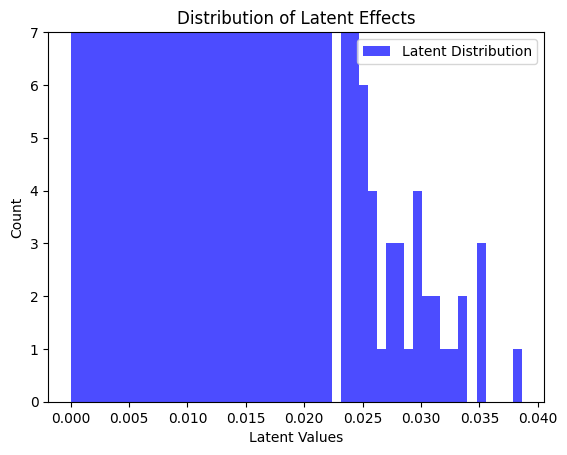

In [150]:
# look at the distribution of the latents
plt.hist(torch.abs(saes[1].igmask.ig_scores).view(-1).cpu().numpy(), bins=50, alpha=0.7, color='blue', label='Latent Distribution')
plt.xlabel('Latent Values')
plt.ylabel('Count')
plt.title('Distribution of Latent Effects')
plt.ylim(0, 7)
plt.legend()
# plot the histogram
plt.show()

7
tensor(24., device='cuda:0')
14
tensor(24., device='cuda:0')
21
tensor(24., device='cuda:0')
40
tensor(24., device='cuda:0')
total tensor(96., device='cuda:0')


In [210]:
saes[0].igmask.get_threshold_info(0.0)

{'total_latents': tensor(9921., device='cuda:0'),
 'avg_latents_per_tok': tensor(152.6308, device='cuda:0'),
 'latents_per_tok': tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,  616.,  108.,   77.,   69.,  102.,   66.,
           63.,  851.,  113.,   75.,   83.,  133.,   72.,   75.,  853.,  107.,
           68.,   81.,  145.,   75.,   72., 1164.,  128.,   72.,   94.,  177.,
           78.,   79., 1278.,  130.,   72.,  101.,  200.,   57.,   63.,  202.,
          137.,   72., 1724.,  105.,   84.], device='cuda:0')}

In [234]:
def pp(x):
    keys = list(x.keys())
    values = list(x.values())
    for i in range(len(keys)):
        print(f"{keys[i]}: {values[i]}")

In [278]:
threshold = 0.01
sum = 0
for sae in saes:
    print("layer:", sae.cfg.hook_layer)
    latents_in_sae = sae.igmask.get_threshold_info(threshold)['total_latents'].item()
    sum += latents_in_sae
    print(latents_in_sae)

print("total", sum)

print("="*40)
with torch.no_grad():
    ig_logitfn = build_sae_logitfn(ig_mask_threshold=threshold, mean_mask=True)
    metrics = sanity_check_model_performance(ig_logitfn)
    top1_correct_avg = (metrics['top1_correct'] + metrics['top1_error'])/2
    ce_avg = (metrics['ce_loss_correct'] + metrics['ce_loss_error'])/2
    pp(metrics)
    print("avg top1 correct", top1_correct_avg)
    print("avg CE loss", ce_avg)

layer: 7
41.0
layer: 14
68.0
layer: 21
259.0
layer: 40
169.0
total 537.0
prob_age_given_correct: 0.7726824879646301
prob_traceback_given_correct(bad): 0.0485164113342762
logit_diff_correct(-=bad): 4.449377536773682
top1_correct: 1.0
ce_loss_correct: 0.2949782907962799
prob_traceback_given_error: 0.22669103741645813
prob_age_given_error(bad): 0.21272730827331543
logit_diff_error(-=bad): 2.172041654586792
top1_error: 1.0
ce_loss_error: 1.4843857288360596
avg top1 correct 1.0
avg CE loss 0.8896820098161697


In [165]:
saes[0].igmask.ig_scores.shape[]

tensor(0., device='cuda:0')

# Optimize Binary Mask

In [114]:
batch_size = 16
simple_dataset = simple_dataset[:batch_size*(len(simple_dataset)//batch_size)]
simple_labels = simple_labels[:batch_size*(len(simple_labels)//batch_size)]

simple_dataset = simple_dataset.view(-1, batch_size, 65)
simple_labels = simple_labels.view(-1, batch_size)

In [115]:
def logitfn(tokens):
    return model.run_with_hooks(
        tokens, 
        return_type="logits", 
        fwd_hooks=build_hooks_list(tokens, use_mask=True, mean_mask=True)
        )

def forward_pass(batch, labels, logitfn, ratio_trained=1):
    for sae in saes:
        sae.mask.ratio_trained = ratio_trained
    tokens = batch
    logits = logitfn(tokens)
    last_token_logits = logits[:, -1, :]
    loss = F.cross_entropy(last_token_logits, labels)
    sparsity_loss = 0
    for sae in saes:
        sparsity_loss = sparsity_loss + sae.mask.sparsity_loss
    
    sparsity_loss = sparsity_loss / len(saes)
    return loss, sparsity_loss

In [116]:
def mask_logits(logits):
    """
    Mask logits to only allow tokens in vocab_tensor by setting all other logits to -inf.
    Works with any number of leading batch dimensions.
    
    Args:
        logits: Tensor of shape [..., vocab_size] containing the logits
    
    Returns:
        Tensor of same shape as logits with all non-vocab logits set to -inf
    """
    vocab_tensor = simple_labels.view(-1).unique()
    mask = torch.zeros_like(logits)
    mask[..., vocab_tensor] = 1
    return logits.masked_fill(mask == 0, float('-inf'))

In [117]:
def do_training_run(sparsity_multiplier, loss_function='ce', per_token_mask=False, use_mask=False, mean_mask=False, distinct_sparsity_multiplier=0):

    def logitfn(tokens):
        logits =  model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens, use_mask=use_mask, mean_mask=mean_mask)
            )
        if loss_function == 'ce_vocab':
            return mask_logits(logits)
        return logits

    def forward_pass(batch, labels, logitfn, ratio_trained=1):
        for sae in saes:
            sae.mask.ratio_trained = ratio_trained
        tokens = batch
        logits = logitfn(tokens)
        last_token_logits = logits[:, -1, :]
        if loss_function == 'ce' or loss_function == 'ce_vocab':
            loss = F.cross_entropy(last_token_logits, labels)
            
        elif loss_function == 'logit_diff':
            # from the last token logits, get the logit for the "1" token and the "Traceback" token
            correct_logits = last_token_logits[torch.arange(last_token_logits.shape[0]), labels]
            incorrect_labels = torch.where(labels == answer_token, traceback_token, answer_token)
            incorrect_logits = last_token_logits[torch.arange(last_token_logits.shape[0]), incorrect_labels]
            loss = (incorrect_logits - correct_logits).mean() # it should very negative if the model is right.
        else:
            raise ValueError(f"Loss function {loss_function} not recognized")
        sparsity_loss = 0
        if per_token_mask:
            distinct_sparsity_loss = 0
        for sae in saes:
            sparsity_loss = sparsity_loss + sae.mask.sparsity_loss
            if per_token_mask:
                distinct_sparsity_loss = distinct_sparsity_loss + sae.mask.distinct_sparsity_loss
        
        sparsity_loss = sparsity_loss / len(saes)
        distinct_sparsity_loss = distinct_sparsity_loss / len(saes)

        return loss, sparsity_loss, distinct_sparsity_loss

    print("doing a run with sparsity multiplier", sparsity_multiplier)
    all_optimized_params = []
    config = {
        "batch_size": 16,
        "learning_rate": 0.05,
        "total_steps": simple_dataset.shape[0]*0.01,
        "sparsity_multiplier": sparsity_multiplier
    }

    for sae in saes:
        if per_token_mask:
            sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=65, distinct_l1=1.0)
        else:
            sae.mask = SparseMask(sae.cfg.d_sae, 1.0)
        all_optimized_params.extend(list(sae.mask.parameters()))
        sae.mask.max_temp = torch.tensor(200.0)
    
    wandb.init(project="sae circuits", config=config)
    optimizer = optim.Adam(all_optimized_params, lr=config["learning_rate"])
    total_steps = config["total_steps"]

    with tqdm(total=total_steps, desc="Training Progress") as pbar:
        for i, (x, y) in enumerate(zip(simple_dataset, simple_labels)):
            with KeyboardInterruptBlocker():
                optimizer.zero_grad()
                
                # Calculate ratio trained
                ratio_trained = i / total_steps
                
                # Update mask ratio for each SAE
                for sae in saes:
                    sae.mask.ratio_trained = ratio_trained
                
                # Forward pass with updated ratio_trained
                loss, sparsity_loss, distinct_sparsity_loss = forward_pass(x, y, logitfn, ratio_trained=ratio_trained)
                if per_token_mask:
                    sparsity_loss = sparsity_loss / 65


                avg_nonzero_elements = sparsity_loss
                avg_distinct_nonzero_elements = distinct_sparsity_loss
                    
                sparsity_loss = sparsity_loss * config["sparsity_multiplier"] + distinct_sparsity_loss * distinct_sparsity_multiplier
                total_loss = loss + sparsity_loss
                infodict  = {"Step": i, "Progress": ratio_trained, "Avg Nonzero Elements": avg_nonzero_elements.item(), "avg distinct lat/sae":avg_distinct_nonzero_elements.item(), "Task Loss": loss.item(), "Sparsity Loss": sparsity_loss.item(), "temperature": saes[0].mask.temperature}
                wandb.log(infodict)
                
                # Backward pass and optimizer step
                total_loss.backward()
                optimizer.step()
                
                # Update tqdm bar with relevant metrics
                pbar.set_postfix(infodict)
                
                # Update the tqdm progress bar
                pbar.update(1)
                if i >= total_steps*1.3:
                    break
    wandb.finish()

    optimizer.zero_grad()

    for sae in saes:
        for param in sae.parameters():
            param.grad = None
        for param in sae.mask.parameters():
            param.grad = None
    
    for param in model.parameters():
        param.grad = None

    torch.cuda.empty_cache()

    mask_dict = {}

    total_density = 0
    for sae in saes:
        mask_dict[sae.cfg.hook_name] = torch.where(torch.sigmoid(sae.mask.mask*10000))[0].tolist()   # rob thinks .view(-1) needed here
        total_density += torch.sigmoid(sae.mask.mask*10000).sum().item()
    mask_dict["total_density"] = total_density
    mask_dict['avg_density'] = total_density / len(saes)

    if per_token_mask:
        print("total # latents in circuit: ", total_density)
    print("avg density", mask_dict['avg_density'])

    ### EVAL ###
    def masked_logit_fn(tokens):
        logits =  model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens, use_mask=use_mask, mean_mask=mean_mask, binarize_mask=True)
            )
        if loss_function == 'ce_vocab':
            return mask_logits(logits)
        return logits

    def eval_ce_loss(batch, labels, logitfn, ratio_trained=10):
        for sae in saes:
            sae.mask.ratio_trained = ratio_trained
        tokens = batch
        logits = logitfn(tokens)
        last_token_logits = logits[:, -1, :]
        loss = F.cross_entropy(last_token_logits, labels)

        # sparsity_loss = 0
        # for sae in saes:
        #     sparsity_loss = sparsity_loss + sae.mask.sparsity_loss
        
        # sparsity_loss = sparsity_loss / len(saes)

        return loss

    with torch.no_grad():
        loss = eval_ce_loss(simple_dataset[-1], simple_labels[-1], masked_logit_fn)
        print("CE loss:", loss)

    mask_dict['ce_loss'] = loss.item()


    json.dump(mask_dict, open(f"{str(sparsity_multiplier)}_run.json", "w"))
    
    

In [118]:
def masked_logit_fn(tokens):
    return model.run_with_hooks(
        tokens, 
        return_type="logits", 
        fwd_hooks=build_hooks_list(tokens, use_mask=True, mean_mask=True, binarize_mask=True)
        )

def eval_ce_loss(batch, labels, logitfn, ratio_trained=10):
    for sae in saes:
        sae.mask.ratio_trained = ratio_trained
    tokens = batch
    logits = logitfn(tokens)
    last_token_logits = logits[:, -1, :]
    loss = F.cross_entropy(last_token_logits, labels)

    # sparsity_loss = 0
    # for sae in saes:
    #     sparsity_loss = sparsity_loss + sae.mask.sparsity_loss
    
    # sparsity_loss = sparsity_loss / len(saes)

    return loss

with torch.no_grad():
    loss = eval_ce_loss(simple_dataset[21], simple_labels[21], masked_logit_fn)
    
    print("CE loss:", loss)



CE loss: tensor(0.6530, device='cuda:0')


In [1]:
# do_training_run(14, loss_function='logit_diff', per_token_mask=True, use_mask=True, mean_mask=True)
# do_training_run(0.1, loss_function="ce", per_token_mask=True, use_mask=True, mean_mask=True, distinct_sparsity_multiplier=0.02)
# do_training_run(0.025, per_token_mask=False, use_mask=True, mean_mask=True)
do_training_run(0.6, loss_function="ce", per_token_mask=True, use_mask=True, mean_mask=True)


NameError: name 'do_training_run' is not defined

In [282]:
def logitfn(tokens, vocab_mask=False):
    logits =  model.run_with_hooks(
        tokens, 
        return_type="logits", 
        fwd_hooks=build_hooks_list(tokens, use_mask=True, mean_mask=True, binarize_mask=True)
        )
    if vocab_mask:
        return mask_logits(logits)
    return logits


In [289]:
with torch.no_grad():
    pp(sanity_check_model_performance(logitfn))

prob_age_given_correct: 0.874530017375946
prob_traceback_given_correct(bad): 0.03809851035475731
logit_diff_correct(-=bad): 4.940079689025879
top1_correct: 1.0
ce_loss_correct: 0.13407503068447113
prob_traceback_given_error: 0.6129750609397888
prob_age_given_error(bad): 0.131747767329216
logit_diff_error(-=bad): 2.947051525115967
top1_error: 1.0
ce_loss_error: 0.48943108320236206


In [161]:
def logitfn(tokens, vocab_mask=False):
    logits =  model.run_with_hooks(
        tokens, 
        return_type="logits", 
        fwd_hooks=build_hooks_list(tokens, use_mask=True, mean_mask=True, binarize_mask=True)
        )
    if vocab_mask:
        return mask_logits(logits)
    return logits

# def forward_pass(batch, labels, logitfn, ratio_trained=1):
#     for sae in saes:
#         sae.mask.ratio_trained = ratio_trained
#     tokens = batch
#     logits = logitfn(tokens)
#     last_token_logits = logits[:, -1, :]
#     loss = F.cross_entropy(last_token_logits, labels)
#     sparsity_loss = 0
#     for sae in saes:
#         sparsity_loss = sparsity_loss + sae.mask.sparsity_loss
    
#     sparsity_loss = sparsity_loss / len(saes)

    return loss, sparsity_loss
with torch.no_grad():
    idx = 0
    print("original example")
    print(f"{model.to_string(simple_dataset[-1][idx])}")
    print("original label")
    print(model.to_string(simple_labels[-1][idx:idx+1]))
    logits = logitfn(simple_dataset[-1][idx:idx+1][-1])[-1][-1]
    print(logits.shape)
    probs = F.softmax(logits, dim=-1)
    print(probs.shape)
    # get the top 3 tokens and their probabilities
    topk = torch.topk(probs, k=3)
    print(model.to_str_tokens(topk.indices))
    print(topk.values)
    # get the cross entropy loss
    loss = F.cross_entropy(logits.unsqueeze(0), simple_labels[-1][idx:idx+1])
    print(f"ce loss {loss}")

with torch.no_grad():
    correct = 0
    num_items = 16
    for i in range(num_items):
        example = simple_dataset[-2][i]
        label = simple_labels[-2][i]
        logits = logitfn(example)[-1][-1]
        top_logit = torch.argmax(logits)
        if top_logit == label:
            print("correct", model.to_string(label))
            correct += 1
        else:
            print("error", model.to_string(label))
        
    print(f"correct: {correct} out of {num_items}")

original example
<bos>Type "help", "copyright", "credits" or "license" for more information.
>>> age = {'Bob': 14, 'Lucas': 12, 'Rob': 15, 'Jackson': 11, 'Tom': 11}
>>> age["Jackson"]

original label
1
torch.Size([256000])
torch.Size([256000])
['1', '>>>', '2']
tensor([0.8805, 0.0355, 0.0118], device='cuda:0')
ce loss 0.12732182443141937
correct 1
correct Traceback
correct Traceback
correct Traceback
correct 1
correct 1
correct 1
correct Traceback
correct 1
correct 1
correct Traceback
correct 1
correct Traceback
correct Traceback
correct Traceback
correct 1
correct: 16 out of 16


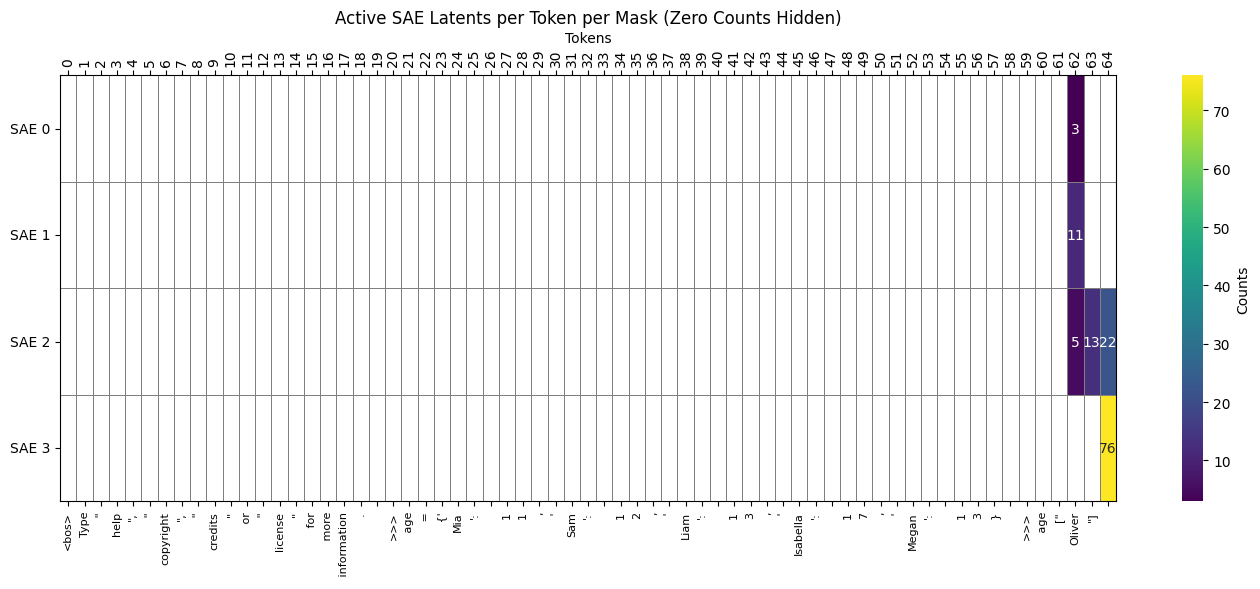

layer 0 latents: 3 🖕
layer 1 latents: 11 🖕
layer 2 latents: 40 🖕
layer 3 latents: 76 🖕
total # latents: 130 🖕


In [288]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm

# Assuming 'saes', 'model', and 'simple_dataset' are defined
tokens = model.to_str_tokens(simple_dataset[2][0])
num_masks = 4 # Number of masks you have
counts_per_mask = []
for mask_index in range(num_masks):
    testmask = saes[mask_index].mask.mask.data.clone()
    binarized = (testmask > 0.0).float()
    counts = []
    for i in range(len(tokens)):
        counts.append(torch.count_nonzero(binarized[i]).item())
    counts_per_mask.append(counts)

# Convert counts to a NumPy array
data = np.array(counts_per_mask) # Shape: (num_masks, num_tokens)

# Create a mask for zero values
zero_mask = data == 0

# Define a colormap
cmap = sns.color_palette("viridis", as_cmap=True)

# Plot the heatmap with the mask
plt.figure(figsize=(14, 6))
ax = sns.heatmap(
    data,
    annot=True,
    fmt='d',
    cmap=cmap,
    mask=zero_mask,
    cbar_kws={'label': 'Counts'},
    linewidths=0.5,
    linecolor='gray'
)

# Set x-axis labels to tokens
ax.set_xticks(np.arange(len(tokens)) + 0.5)
ax.set_xticklabels(tokens, rotation=90, fontsize=8)

# Add numeric indices above the chart
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(np.arange(len(tokens)) + 0.5)
ax2.set_xticklabels(np.arange(len(tokens)), rotation=90)  # Rotate indices 90 degrees
ax2.set_xlabel('Token Indices')

# Set y-axis labels to masks
ax.set_yticks(np.arange(num_masks) + 0.5)
ax.set_yticklabels([f'SAE {i}' for i in range(num_masks)], rotation=0)

plt.xlabel('Tokens')
plt.ylabel('SAE Number Active Latents')
plt.title('Active SAE Latents per Token per Mask (Zero Counts Hidden)')
plt.tight_layout()
plt.show()

# print the total # latents in the circuit
total_latents = 0
for i, sae in enumerate(saes):
    print(f"layer {i} latents: {torch.sum(sae.mask.mask > 0)} 🖕")
    total_latents += torch.sum(sae.mask.mask > 0)
print(f"total # latents: {total_latents} 🖕")


In [120]:
torch.nonzero(saes[2].mask.mask[64]>0)

tensor([[   52],
        [  639],
        [  712],
        [  718],
        [ 1197],
        [ 1408],
        [ 4708],
        [ 6650],
        [ 7192],
        [ 8082],
        [ 8127],
        [ 9551],
        [10003],
        [11135],
        [12314],
        [12598]], device='cuda:0')

In [119]:
print(model.to_string(simple_dataset[0][2]))

<bos>Type "help", "copyright", "credits" or "license" for more information.
>>> age = {'Isabella': 49, 'Emma': 78, 'Tom': 27, 'Ethan': 48, 'Ava': 62}
>>> age["Ava"]



## HPRAM sweep

In [ ]:
1/25

0.04

In [ ]:
# 1/10 -> 1/100
num_runs = 10

start = 1/15
end = 1/100
step = (end-start)/num_runs

for i in range(num_runs):
    sparsity_multiplier = start + i*step
    print(f"Starting run with sparsity multiplier {sparsity_multiplier}")
    do_training_run(sparsity_multiplier)

Starting run with sparsity multiplier 0.06666666666666667
doing a run with sparsity multiplier 0.06666666666666667


Training Progress:   5%|▍         | 6/125.0 [00:10<03:28,  1.75s/it, Step=5, Progress=0.04, Avg Nonzero Elements=1.17e+4, Task Loss=5.53, Sparsity Loss=783, temperature=tensor(1.2361, device='cuda:0')] 


KeyboardInterrupt: 

## Eval

In [ ]:
def masked_logit_fn(tokens):
    return model.run_with_hooks(
        tokens, 
        return_type="logits", 
        fwd_hooks=build_hooks_list(tokens, use_mask=True, binarize_mask=True, mean_mask=True)
        )

In [ ]:
def baseline_logit_fn(tokens):
    return model.run_with_hooks(
        tokens, 
        return_type="logits", 
        fwd_hooks=[]
        )

In [ ]:
def baseline_sae_logit_fn(tokens):
    return model.run_with_hooks(
        tokens, 
        return_type="logits", 
        fwd_hooks=build_hooks_list(tokens)
        )

In [ ]:
# serialize the masks
mask_dict = {}
for sae in saes:
    mask_dict[sae.cfg.hook_name] = torch.where(torch.sigmoid(sae.mask.mask*10000))[0].tolist()

json.dump(mask_dict, open("mask_dict.json", "w"))
len(mask_dict["blocks.7.hook_resid_post"])

5

In [ ]:
for sae in saes:
    mask = sae.mask.mask
    print(f"Nonzero elements in mask for {sae.cfg.hook_name}: {torch.count_nonzero(torch.sigmoid(mask*1000))}")

Nonzero elements in mask for blocks.7.hook_resid_post: 5
Nonzero elements in mask for blocks.14.hook_resid_post: 13
Nonzero elements in mask for blocks.21.hook_resid_post: 20
Nonzero elements in mask for blocks.40.hook_resid_post: 45


In [ ]:
def eval_ce_loss(batch, labels, logitfn, ratio_trained=10):
    for sae in saes:
        sae.mask.ratio_trained = ratio_trained
    tokens = batch
    logits = logitfn(tokens)
    last_token_logits = logits[:, -1, :]
    loss = F.cross_entropy(last_token_logits, labels)
    sparsity_loss = 0
    for sae in saes:
        sparsity_loss = sparsity_loss + sae.mask.sparsity_loss
    
    sparsity_loss = sparsity_loss / len(saes)

    return loss

with torch.no_grad():
    loss = eval_ce_loss(simple_dataset[-1], simple_labels[-1], baseline_logit_fn)
    print("baseline loss:", loss)

with torch.no_grad():
    loss = eval_ce_loss(simple_dataset[-1], simple_labels[-1], baseline_sae_logit_fn)
    print("sae loss: ", loss)

with torch.no_grad():
    loss = eval_ce_loss(simple_dataset[-1], simple_labels[-1], masked_logit_fn)
    print("ablated loss: ", loss)

baseline loss: tensor(0.0276, device='cuda:0')
sae loss:  tensor(0.8250, device='cuda:0')
ablated loss:  tensor(0.4248, device='cuda:0')


In [ ]:
def eval_ce_loss(batch, labels, logitfn, ratio_trained=10):
    # Assuming 'saes' is defined elsewhere in your code
    for sae in saes:
        sae.mask.ratio_trained = ratio_trained
    tokens = batch
    logits = logitfn(tokens)
    last_token_logits = logits[:, -1, :]
    loss = F.cross_entropy(last_token_logits, labels)
    sparsity_loss = 0
    for sae in saes:
        sparsity_loss += sae.mask.sparsity_loss
    
    sparsity_loss = sparsity_loss / len(saes)
    total_loss = loss + sparsity_loss

    return loss.item()  # Return the loss as a scalar value



In [ ]:
results_list = []

# Method: VANILLA GEMMA 9B
method_name = "VANILLA GEMMA 9B"
with torch.no_grad():
    results = sanity_check_model_performance(baseline_logit_fn)
    # Compute cross-entropy loss
    ce_loss = eval_ce_loss(simple_dataset[-1], simple_labels[-1], baseline_logit_fn)
    results['ce_loss'] = ce_loss
    results['method'] = method_name
    results_list.append(results)

# Method: GEMMA 9B WITH SAE (no masks)
method_name = "GEMMA 9B WITH SAE (no masks)"
with torch.no_grad():
    results = sanity_check_model_performance(baseline_sae_logit_fn)
    # Compute cross-entropy loss
    ce_loss = eval_ce_loss(simple_dataset[-1], simple_labels[-1], baseline_sae_logit_fn)
    results['ce_loss'] = ce_loss
    results['method'] = method_name
    results_list.append(results)

# Method: GEMMA 9B WITH SAE Masked
method_name = "GEMMA 9B WITH SAE Masked"
with torch.no_grad():
    results = sanity_check_model_performance(masked_logit_fn)
    # Compute cross-entropy loss
    ce_loss = eval_ce_loss(simple_dataset[-1], simple_labels[-1], masked_logit_fn)
    results['ce_loss'] = ce_loss
    results['method'] = method_name
    results_list.append(results)

# Create a DataFrame and display it with descriptive column names
df = pd.DataFrame(results_list)
df = df.set_index('method')  # Set 'method' as the index

# Rename columns for better readability
df = df.rename(columns={
    'prob_correct_in_correct': 'P(Age|Correct Ex)',
    'prob_error_in_correct': 'P(Traceback|Correct Ex)',
    'logit_diff_correct': 'Logit Diff (Correct Ex)',
    'prob_error_in_error': 'P(Traceback|Error Ex)',
    'prob_correct_in_error': 'P(Age|Error Ex)',
    'logit_diff_error': 'Logit Diff (Error Ex)',
    'ce_loss': 'Cross-Entropy Loss'
})

# Display the DataFrame
df


,P(Age|Correct Ex),P(Traceback|Correct Ex),Logit Diff (Correct Ex),P(Traceback|Error Ex),P(Age|Error Ex),Logit Diff (Error Ex),Cross-Entropy Loss
method,,,,,,,
VANILLA GEMMA 9B,0.979983,0.001325,6.898462,0.959781,0.000997,6.925329,0.027596
GEMMA 9B WITH SAE (no masks),0.929262,0.001051,6.914926,0.176590,0.025586,2.025202,0.825018
GEMMA 9B WITH SAE Masked,0.828356,0.015461,4.076188,0.469673,0.076615,1.813243,0.424774


# Analyze Single Fwd Pass

In [236]:
def logitfn(tokens):
    return model.run_with_hooks(
        tokens, 
        return_type="logits", 
        fwd_hooks=build_hooks_list(tokens, use_mask=True, mean_mask=True, binarize_mask=True, cache_masked_activations=True)
        )

# def forward_pass(batch, labels, logitfn, ratio_trained=1):
#     for sae in saes:
#         sae.mask.ratio_trained = ratio_trained
#     tokens = batch
#     logits = logitfn(tokens)
#     last_token_logits = logits[:, -1, :]
#     loss = F.cross_entropy(last_token_logits, labels)
#     sparsity_loss = 0
#     for sae in saes:
#         sparsity_loss = sparsity_loss + sae.mask.sparsity_loss
    
#     sparsity_loss = sparsity_loss / len(saes)

    return loss, sparsity_loss
with torch.no_grad():
    idx = 15
    print("original example")
    print(f"{model.to_string(simple_dataset[-1][idx])}")
    print("original label")
    print(model.to_string(simple_labels[-1][idx:idx+1]))
    logits = logitfn(simple_dataset[-1][idx:idx+1][-1])[-1][-1]
    print(logits.shape)
    probs = F.softmax(logits, dim=-1)
    print(probs.shape)
    # get the top 3 tokens and their probabilities
    topk = torch.topk(probs, k=3)
    print(model.to_str_tokens(topk.indices))
    print(topk.values)
    # get the cross entropy loss
    loss = F.cross_entropy(logits.unsqueeze(0), simple_labels[-1][idx:idx+1])
    print(f"ce loss {loss}")


original example
<bos>Type "help", "copyright", "credits" or "license" for more information.
>>> age = {'Sally': 17, 'Rob': 57, 'Sam': 20, 'Bob': 54, 'Sophia': 20}
>>> age["Sophia"]

original label
2
torch.Size([256000])
torch.Size([256000])
['2', '5', '>>>']
tensor([0.3331, 0.3140, 0.0836], device='cuda:0')
ce loss 1.0994288921356201


In [237]:
(saes[0].mask.mask>0).sum()

tensor(167, device='cuda:0')

In [180]:
(saes[0].feature_acts>0).sum()

tensor(24752, device='cuda:0')

In [308]:
def get_acts(sae):
    acts = sae.feature_acts
    # print(acts.shape)
    mask = sae.mask.mask > 0
    # print(mask.shape)
    # where the mask is true, leave acts alone, otherwise set to 0
    masked_acts = acts * mask
    return masked_acts

# IMPORTANT: the mask masks out the first token, so we don't need to worry about killing BOS token
acts = get_acts(saes[1]).squeeze()

In [309]:
active_latents = torch.nonzero(acts)

In [ ]:
active_latents



tensor([[   24,    30],
        [   24, 12239],
        [   24, 15305],
        [   27,   534],
        [   27, 11578],
        [   28,  3178],
        [   28,  4458],
        [   28,  8321],
        [   28, 13170],
        [   28, 15646],
        [   34,  2038],
        [   35,  3742],
        [   35, 13170],
        [   38,    30],
        [   38,  3751],
        [   41,   534],
        [   41,  7560],
        [   42, 10076],
        [   42, 13170],
        [   48,   534],
        [   48,  2038],
        [   48,  4170],
        [   49,  3178],
        [   49,  4458],
        [   49, 13170],
        [   52,    30],
        [   52,  3751],
        [   52, 15305],
        [   56, 13170],
        [   62,    30],
        [   62,  1788],
        [   62,  2576],
        [   62,  3742],
        [   62,  3751],
        [   62,  3805],
        [   62,  4811],
        [   62,  6150],
        [   62,  8269],
        [   62,  8629],
        [   62,  8657],
        [   62,  8746],
        [   62, 

In [311]:
active_latents[3]

tensor([ 27, 534], device='cuda:0')

In [333]:
circuit_latent_idx = 32

tokens = model.to_str_tokens(simple_dataset[-1][idx])

token_index, latent_index = active_latents[circuit_latent_idx]
print("token:", tokens[token_index])

# Create a copy of tokens so we can modify the one to highlight
highlighted_tokens = tokens[:]
highlighted_tokens[token_index] = f"<<{highlighted_tokens[token_index]}>>"

# Join the tokens back into a string
print("".join(highlighted_tokens))

link = f"https://www.neuronpedia.org/gemma-2-9b/14-gemmascope-res-16k/{latent_index}"
print(link)


token: Sophia
<bos>Type "help", "copyright", "credits" or "license" for more information.
>>> age = {'Sally': 17, 'Rob': 57, 'Sam': 20, 'Bob': 54, 'Sophia': 20}
>>> age["<<Sophia>>"]

https://www.neuronpedia.org/gemma-2-9b/14-gemmascope-res-16k/3742


In [1]:
from neuronpedia_api import get_sae_activations_annotated

get_sae_activations_annotated(14, 30)

['mu}\\mkern2mu })({\\mkern2mu\\underline{\\mkern-2mu\\<<smash{\\>>tilde{K}}\\mkern-2mu}\\mkern2mu }_{\\alpha }(\\<<xi>> )-\\tilde{K}_{\\alpha }(\\<<xi>> )),  \\label{<<sx}$$>> where $\\tilde{K}_{C}^{I}(\\<<xi>> )=K_{C}^{I}$, $$\\tilde{K}_{\\phi }^{i}(\\<<xi>> )=K_{\\phi }^{i}-\\<<xi>> \\bar{C}^{I\\hspace{0.01in}}G^{Ii}({\\mkern2mu\\underline{\\mkern-',
 ' is shown in Fig.\xa0\\[fig:<<Sk>>\\]. It is worth mentioning that our numerical study corresponds to $B\\<<sim>>{}D$, so the radius of the<< skyrmion>> is equal to $\\rho_{0}\\<<sim>>4<<Sa>>$, which is of the order of a few lattice sites. Although for these values of the magnetic field the micromagnetic model is not applicable, because the magnetization changes a lot from site to site, it provides a good qualitative understanding of the<< skyrm>>ionic behavior and still matches with our numerical<< simulations>>.\n\nThe corresponding<< skyrmion>> number in a two-dimensional system is defined as $$\\begin{',
 '  "Cpu0P<<sd>>",\r\n  0x

# Group features by Correlations

In [ ]:
# load_sparsemask("0.025_run.json")

In [ ]:
model.to_str_tokens(example).index("Emily")

24

In [ ]:
model.to_str_tokens(example)[27]


'2'

In [ ]:
model.to_tokens("he was 11")

tensor([[     2,    480,    729, 235248, 235274, 235274]], device='cuda:0')

In [ ]:
example = simple_dataset[-2].clone()
example[27] = 235284 # 2
# example[28] = 235274 # 1
model.to_string(example)


'<bos>Type "help", "copyright", "credits" or "license" for more information.\n>>> age = {\'Emily\': 27, \'James\': 13, \'Megan\': 17, \'Rob\': 14, \'Sam\': 14}\n>>> age["Emily"]\n'

In [ ]:
# 1. iterate over last 10 examples
data = simple_dataset[-10:]
cached_activations = []
with torch.no_grad():
    def model_forward_pass(tokens):
        return model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens, use_mask=True, binarize_mask=True, cache_masked_activations=True)
            )
    for example in data:
        logits = model_forward_pass(example)
        cache = {}
        for sae in saes:
            cache[sae.cfg.hook_name] = sae.feature_acts
        cached_activations.append(cache)

    # print(model.to_string(example))
    # logits = model_forward_pass(example)
    # # logits = model_forward_pass(model.to_tokens("The sky is"))
    # print(model.to_str_tokens(torch.topk(F.softmax(logits[:, -1, :], dim=-1), k=3).indices))
    # print(torch.topk(F.softmax(logits[:, -1, :], dim=-1), k=3).values)

In [ ]:
idx = 0
print(torch.where(cached_activations[0]["blocks.7.hook_resid_post"][0][-5]))


print(model.to_string(data[0]))
print(model.to_str_tokens(data[0])[-5])

(tensor([   75,  1575,  3231,  3524,  7008, 10180, 10647, 10768, 11635, 11740,
        12571], device='cuda:0'),)
<bos>Type "help", "copyright", "credits" or "license" for more information.
>>> age = {'Sam': 11, 'Noah': 16, 'Megan': 19, 'Ava': 10, 'Lilly': 17}
>>> age["Noah"]

 age


In [ ]:
cached_activations[0]["blocks.7.hook_resid_post"].shape

torch.Size([1, 65, 16384])

In [ ]:
keep_locations = torch.where(saes[0].mask.mask>0)[0]
print(keep_locations)

tensor([   75,   351,   488,   632,  1229,  1422,  1575,  1589,  1662,  1935,
         1976,  2467,  2701,  2846,  2881,  3153,  3231,  3257,  3354,  3418,
         3524,  3658,  3784,  3992,  4287,  5196,  5311,  5337,  5459,  5537,
         5587,  5778,  6491,  6500,  6535,  6671,  6800,  6928,  6984,  7008,
         7024,  7323,  7857,  7958,  8146,  8667,  8895,  9046,  9052,  9353,
         9513,  9681,  9843,  9850, 10093, 10094, 10180, 10267, 10647, 10680,
        10768, 10868, 11204, 11526, 11635, 11707, 11740, 12131, 12134, 12275,
        12387, 12407, 12571, 12880, 12956, 13383, 13630, 13635, 13694, 14249,
        14309, 14342, 14567, 14615, 14827, 15328, 15462, 15613, 15678, 15738,
        15796], device='cuda:0')


In [ ]:
block_seven_cache = torch.cat([cached_activations[i]["blocks.7.hook_resid_post"] for i in range(10)], dim=0)
block_seven_cache = block_seven_cache[:, 1:, :].contiguous()
block_seven_cache = block_seven_cache.view(-1, block_seven_cache.shape[-1])
block_seven_cache = block_seven_cache[:, keep_locations]

In [ ]:
block_seven_cache

tensor([[18.6473,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [24.8756,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  2.8846],
        [12.3906,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  8.3760],
        ...,
        [16.4783,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [22.2913,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [21.7554,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')

# Circuit Analysis

In [229]:
import torch
from tqdm import tqdm

def logitfn(tokens, use_mask=True, mean_mask=True, binarize_mask=True):
    # This function returns logits while hooking into SAEs
    return model.run_with_hooks(
        tokens, 
        return_type="logits", 
        fwd_hooks=build_hooks_list(tokens, use_mask=use_mask, mean_mask=mean_mask, binarize_mask=binarize_mask, cache_sae_activations=True)
    )

def collect_sae_activations(dataset, batch_size=16, max_batches=None):
    """
    Accumulates SAE latent activations from multiple forward passes.
    Args:
        dataset (Tensor): Shape [num_samples, seq_len]. Tokenized samples.
        batch_size (int): Batch size for processing.
        max_batches (int or None): If set, stop after this many batches.
    Returns:
        A dictionary mapping each SAE hook name to a list of [batch, seq_len, d_sae] tensors.
    """
    # Set SAEs to no gradient mode
    for sae in saes:
        for param in sae.parameters():
            param.requires_grad_(False)

    num_samples = dataset.shape[0]
    num_batches = (num_samples + batch_size - 1) // batch_size
    if max_batches is not None:
        num_batches = min(num_batches, max_batches)

    # Dictionary to hold collected activations
    # Will store a list of activations for each SAE layer.
    collected_activations = {sae.cfg.hook_name: [] for sae in saes}

    with torch.no_grad():
        with tqdm(total=num_batches, desc="Collecting Activations") as pbar:
            for i in range(num_batches):
                batch = dataset[i*batch_size:(i+1)*batch_size]
                
                # Run forward pass
                _ = logitfn(batch)

                # Now each SAE should have stored activations in sae.feature_acts
                for sae in saes:
                    # sae.feature_acts: Shape [batch, seq_len, d_sae]
                    # Append a detached clone so we don't retain graph
                    collected_activations[sae.cfg.hook_name].append(get_acts(sae).detach().clone())
                
                pbar.update(1)

    # Optionally, concatenate all batches for each SAE
    for hook_name in collected_activations:
        collected_activations[hook_name] = torch.cat(collected_activations[hook_name], dim=0)
        # Now shape is [total_samples, seq_len, d_sae]

    return collected_activations


# Example usage:
# Suppose `simple_dataset` is shaped [num_batches, batch_size, seq_len].
# Reshape it or select the portion you want to run over.
analysis_data, analysis_labels = simple_dataset.view(-1, 65)[:256], simple_labels.view(-1)[:256]
# all_data = simple_dataset.reshape(-1, 65)[:1000]  # Just take 1000 samples for demo
collected_acts = collect_sae_activations(analysis_data, batch_size=16, max_batches=30)

# Now 'collected_acts' is a dict:
# {
#    "blocks.7.hook_resid_post": Tensor of shape [N, seq_len, d_sae],
#    "blocks.14.hook_resid_post": ...,
#    "blocks.21.hook_resid_post": ...,
#    "blocks.40.hook_resid_post": ...
# }

# You can now analyze these tensors, compute correlations, cluster them, etc.
# For instance:
for hook_name, acts in collected_acts.items():
    print(f"For {hook_name}, collected shape: {acts.shape}")
    # Do further analysis...


For blocks.7.hook_resid_post, collected shape: torch.Size([256, 65, 16384])
For blocks.14.hook_resid_post, collected shape: torch.Size([256, 65, 16384])
For blocks.21.hook_resid_post, collected shape: torch.Size([256, 65, 16384])
For blocks.40.hook_resid_post, collected shape: torch.Size([256, 65, 16384])


In [230]:
torch.nonzero(saes[2].mask.mask[27]>0)

tensor([[ 2453],
        [ 2498],
        [ 4170],
        [ 4328],
        [ 4513],
        [ 6201],
        [12295],
        [12529],
        [14219],
        [15373]], device='cuda:0')

In [ ]:

def get_masked_indices_and_values(collected_activations):
    """
    Extracts active indices and their corresponding activation values for each SAE.

    Args:
        collected_activations (dict): Dictionary mapping SAE hook names to activation tensors.
                                      Each tensor has shape [num_samples, seq_len, d_sae].
        saes (list): List of SAE objects, each with a `cfg.hook_name` and `mask.mask` attribute.
        device (str): Device to move tensors to (default: 'cpu').

    Returns:
        masked_activations (dict): 
            {
                "hook_name_1": {
                    "indices": [(seq_pos1, d_sae1), (seq_pos2, d_sae2), ...],
                    "values": Tensor of shape [num_samples, num_active_indices]
                },
                "hook_name_2": {
                    "indices": [...],
                    "values": ...
                },
                ...
            }
    """
    masked_activations = {}

    for sae in saes:
        hook_name = sae.cfg.hook_name
        mask = sae.mask.mask  # Shape: [seq_len, d_sae]

        # Find indices where mask > 0
        row_idx, col_idx = torch.where(mask > 0)  # Each is a 1D tensor of indices

        # Convert indices to list of tuples
        active_indices = list(zip(row_idx.tolist(), col_idx.tolist()))

        # Get the corresponding activation tensor
        # Shape of collected_activations[hook_name]: [num_samples, seq_len, d_sae]
        activations = collected_activations[hook_name]  # Tensor on CPU

        # Flatten the [seq_len, d_sae] dimensions to 1D for easy indexing
        num_samples = activations.shape[0]
        flat_activations = activations.view(num_samples, -1)  # Shape: [num_samples, seq_len * d_sae]

        # Compute flat indices
        flat_indices = row_idx * mask.shape[1] + col_idx  # Shape: [num_active_indices]

        # Extract activation values at the masked indices
        # Shape: [num_samples, num_active_indices]
        masked_values = activations[:, row_idx, col_idx]  # More efficient indexing

        # Move to desired device (optional)
        # masked_values = masked_values.to(device)

        # Store in the result dictionary
        masked_activations[hook_name] = {
            "indices": active_indices,
            "values": masked_values  # Tensor: [num_samples, num_active_indices]
        }

    return masked_activations

censored_activations = get_masked_indices_and_values(collected_acts)


In [ ]:
censored_activations['blocks.7.hook_resid_post']

{'indices': [(24, 1598),
  (24, 1675),
  (24, 2617),
  (24, 3781),
  (24, 4203),
  (24, 4276),
  (24, 4384),
  (24, 4468),
  (24, 6342),
  (24, 6624),
  (24, 12664),
  (24, 13973),
  (24, 15380),
  (24, 15709),
  (27, 2157),
  (27, 2498),
  (27, 4958),
  (27, 5337),
  (27, 9299),
  (27, 9843),
  (27, 9938),
  (27, 10501),
  (27, 10665),
  (27, 15003),
  (27, 15041),
  (27, 15880),
  (28, 4094),
  (31, 1675),
  (31, 2617),
  (31, 2846),
  (31, 3781),
  (31, 4276),
  (31, 4384),
  (31, 4468),
  (31, 6342),
  (31, 6624),
  (31, 7386),
  (31, 11204),
  (31, 12664),
  (31, 13973),
  (31, 15380),
  (31, 15709),
  (34, 2157),
  (34, 2498),
  (34, 4958),
  (34, 5337),
  (34, 9299),
  (34, 9843),
  (34, 9938),
  (34, 10501),
  (34, 10665),
  (34, 15041),
  (34, 15880),
  (35, 4094),
  (35, 4958),
  (35, 5311),
  (35, 9052),
  (35, 9938),
  (38, 1675),
  (38, 2617),
  (38, 2846),
  (38, 3781),
  (38, 4276),
  (38, 4384),
  (38, 6342),
  (38, 6624),
  (38, 11204),
  (38, 12664),
  (38, 13973),
  

In [ ]:
torch.save(censored_activations, "masked_activations.pt")

# Cluster circuits

Loading masked activations...
Data shapes:
Layer 7 values shape: torch.Size([256, 167])
Layer 14 values shape: torch.Size([256, 143])

Analyzing layer 7...
Found 129 clusters in layer 7
Cluster 93: 1 features
Cluster 110: 1 features
Cluster 115: 1 features
Cluster 13: 2 features
Cluster 107: 1 features
Cluster 82: 1 features
Cluster 4: 2 features
Cluster 83: 1 features
Cluster 116: 1 features
Cluster 76: 1 features
Cluster 72: 1 features
Cluster 102: 1 features
Cluster 92: 1 features
Cluster 16: 2 features
Cluster 98: 1 features
Cluster 74: 1 features
Cluster 27: 3 features
Cluster 79: 1 features
Cluster 66: 1 features
Cluster 103: 1 features
Cluster 60: 2 features
Cluster 125: 1 features
Cluster 105: 1 features
Cluster 87: 2 features
Cluster 15: 2 features
Cluster 77: 1 features
Cluster 3: 2 features
Cluster 104: 1 features
Cluster 126: 1 features
Cluster 128: 1 features
Cluster 51: 1 features
Cluster 127: 1 features
Cluster 100: 1 features
Cluster 71: 1 features
Cluster 30: 2 feature

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


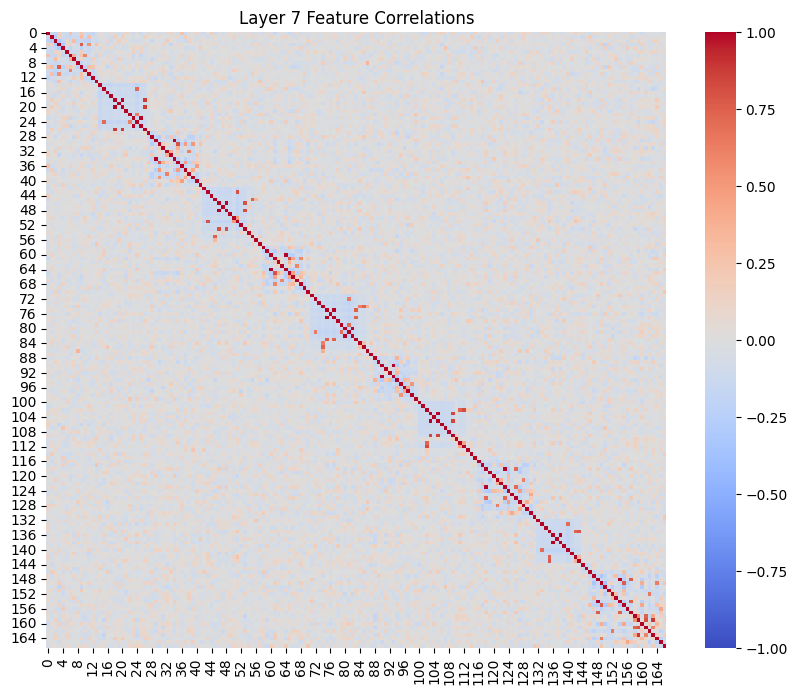

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


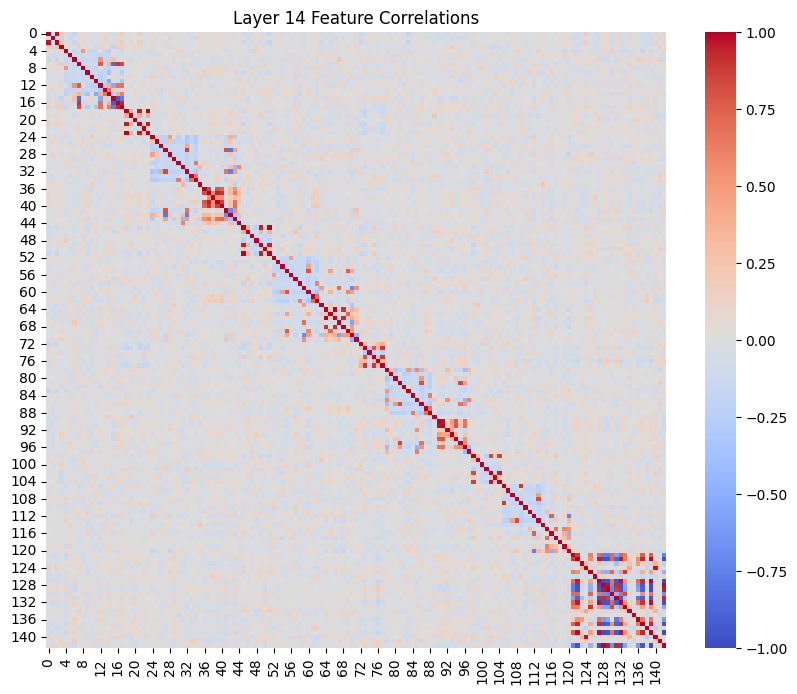

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

def clean_correlation_matrix(corr_matrix):
    """Handle NaN values in correlation matrix."""
    # Handle 1D case (single feature)
    if len(corr_matrix.shape) == 1 or corr_matrix.shape[0] == 1:
        return np.array([[1.0]])
        
    # Replace NaN with 0 correlation
    corr_matrix = np.nan_to_num(corr_matrix, 0)
    # Ensure symmetry
    corr_matrix = (corr_matrix + corr_matrix.T) / 2
    # Ensure diagonal is 1
    np.fill_diagonal(corr_matrix, 1)
    return corr_matrix

class InterpretableSAEMapping:
    def __init__(self, correlation_threshold=0.8):
        self.correlation_threshold = correlation_threshold
        self.feature_clusters = None
        self.cluster_representatives = None
        
    def find_correlated_features(self, activations):
        """Group highly correlated features using hierarchical clustering."""
        # If only one feature, return single cluster
        if activations.shape[1] == 1:
            self.feature_clusters = {0: [0]}
            return self.feature_clusters
            
        # Convert to numpy and handle NaN values
        acts_np = activations.numpy()
        acts_np = np.nan_to_num(acts_np, 0)
        
        # Standardize the features
        scaler = StandardScaler()
        acts_standardized = scaler.fit_transform(acts_np)
        
        # Compute correlation matrix
        correlations = np.corrcoef(acts_standardized.T)
        correlations = clean_correlation_matrix(correlations)
        
        # Convert correlations to distances
        distances = 1 - np.abs(correlations)
        
        # Perform hierarchical clustering
        clustering = AgglomerativeClustering(
            n_clusters=None,
            distance_threshold=1 - self.correlation_threshold,
            metric='precomputed',
            linkage='complete'
        )
        clustering.fit(distances)
        
        # Group features into clusters
        self.feature_clusters = {}
        for feature_idx, cluster_idx in enumerate(clustering.labels_):
            if cluster_idx not in self.feature_clusters:
                self.feature_clusters[cluster_idx] = []
            self.feature_clusters[cluster_idx].append(feature_idx)
        
        return self.feature_clusters

    def get_cluster_representatives(self, activations):
        """Select representative features for each cluster."""
        if not self.feature_clusters:
            return {}
            
        self.cluster_representatives = {}
        acts_np = activations.numpy()
        acts_np = np.nan_to_num(acts_np, 0)
        
        for cluster_idx, feature_indices in self.feature_clusters.items():
            # If cluster has only one feature, it's automatically the representative
            if len(feature_indices) == 1:
                self.cluster_representatives[cluster_idx] = feature_indices[0]
                continue
                
            cluster_activations = acts_np[:, feature_indices]
            cluster_correlations = np.corrcoef(cluster_activations.T)
            cluster_correlations = clean_correlation_matrix(cluster_correlations)
            
            avg_correlations = np.mean(np.abs(cluster_correlations), axis=1)
            representative_idx = feature_indices[np.argmax(avg_correlations)]
            
            self.cluster_representatives[cluster_idx] = representative_idx
            
        return self.cluster_representatives

    def create_interpretable_features(self, activations):
        """Create interpretable features using representatives and means."""
        if not self.feature_clusters or not self.cluster_representatives:
            return activations
            
        interpretable_features = []
        
        for cluster_idx, rep_idx in self.cluster_representatives.items():
            interpretable_features.append(activations[:, rep_idx])
            
            cluster_features = self.feature_clusters[cluster_idx]
            other_features = [idx for idx in cluster_features if idx != rep_idx]
            if other_features:
                cluster_mean = activations[:, other_features].mean(dim=1)
                interpretable_features.append(cluster_mean)
        
        return torch.stack(interpretable_features, dim=1)

# Load and process the data
print("Loading masked activations...")
censored_activations = torch.load("masked_activations.pt")

# Get activations for layers 7 and 14
layer7_data = censored_activations['blocks.7.hook_resid_post']
layer14_data = censored_activations['blocks.14.hook_resid_post']

layer7_values = layer7_data['values'].cpu()
layer14_values = layer14_data['values'].cpu()

print("Data shapes:")
print("Layer 7 values shape:", layer7_values.shape)
print("Layer 14 values shape:", layer14_values.shape)

# Initialize mappers
sae7_mapper = InterpretableSAEMapping(correlation_threshold=0.5)
sae14_mapper = InterpretableSAEMapping(correlation_threshold=0.5)

# Find correlated features
print("\nAnalyzing layer 7...")
layer7_clusters = sae7_mapper.find_correlated_features(layer7_values)
print(f"Found {len(layer7_clusters)} clusters in layer 7")
for i, cluster in layer7_clusters.items():
    print(f"Cluster {i}: {len(cluster)} features")

print("\nAnalyzing layer 14...")
layer14_clusters = sae14_mapper.find_correlated_features(layer14_values)
print(f"Found {len(layer14_clusters)} clusters in layer 14")
for i, cluster in layer14_clusters.items():
    print(f"Cluster {i}: {len(cluster)} features")

# Get representatives and create interpretable features
print("\nGetting cluster representatives...")
layer7_reps = sae7_mapper.get_cluster_representatives(layer7_values)
layer14_reps = sae14_mapper.get_cluster_representatives(layer14_values)

print("\nCreating interpretable features...")
layer7_interpretable = sae7_mapper.create_interpretable_features(layer7_values)
layer14_interpretable = sae14_mapper.create_interpretable_features(layer14_values)

print("\nInterpretable feature shapes:")
print(f"Layer 7: {layer7_interpretable.shape}")
print(f"Layer 14: {layer14_interpretable.shape}")

# Visualize correlation matrices
def plot_correlation_matrix(values, title):
    if values.shape[1] == 1:
        print(f"Skipping correlation plot for {title} - only one feature")
        return
        
    corr = np.corrcoef(values.T)
    corr = clean_correlation_matrix(corr)
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, cmap='coolwarm', center=0, vmin=-1, vmax=1)
    plt.title(title)
    plt.show()

print("\nPlotting correlation matrices...")
plot_correlation_matrix(layer7_values, "Layer 7 Feature Correlations")
plot_correlation_matrix(layer14_values, "Layer 14 Feature Correlations")


Plotting clustered correlation matrices...

Layer 7 clusters:


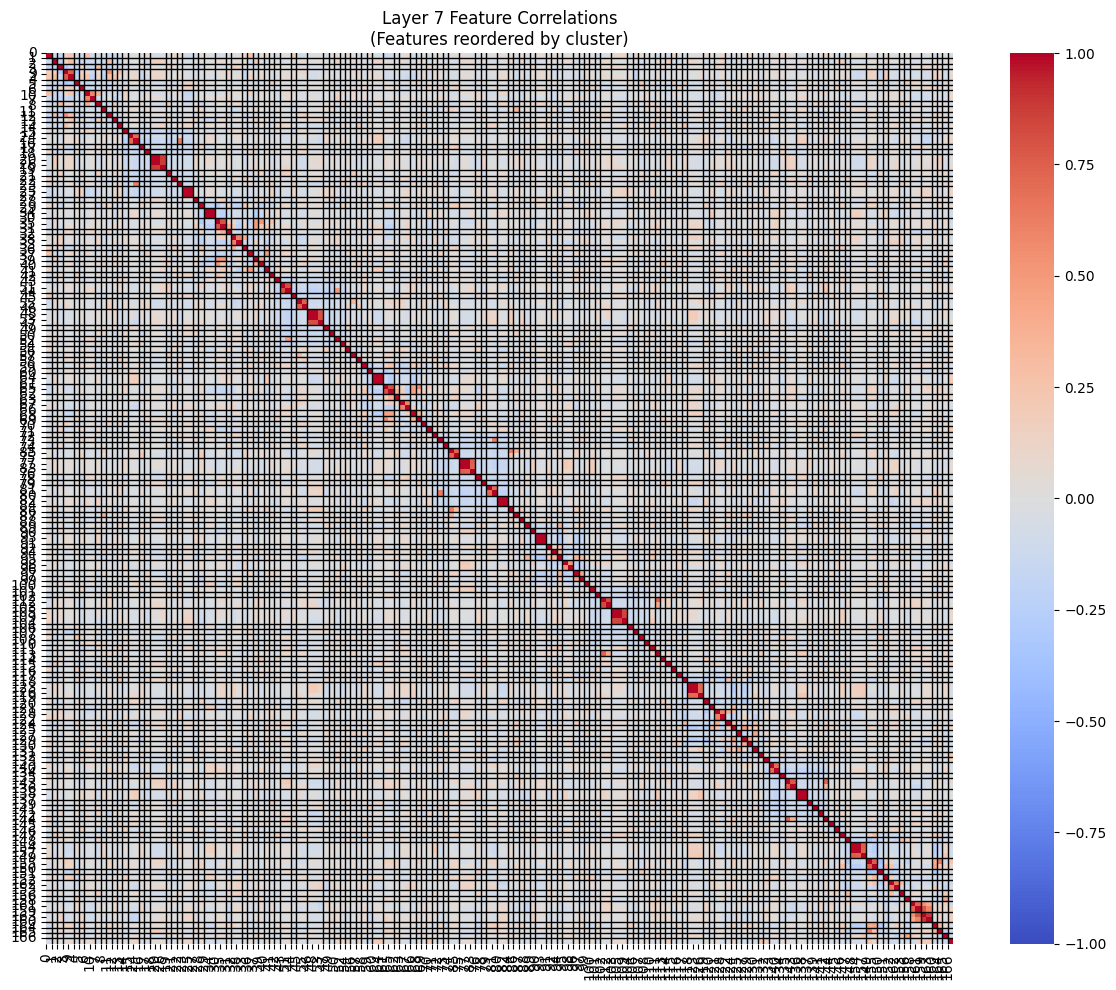


Layer 14 clusters:


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


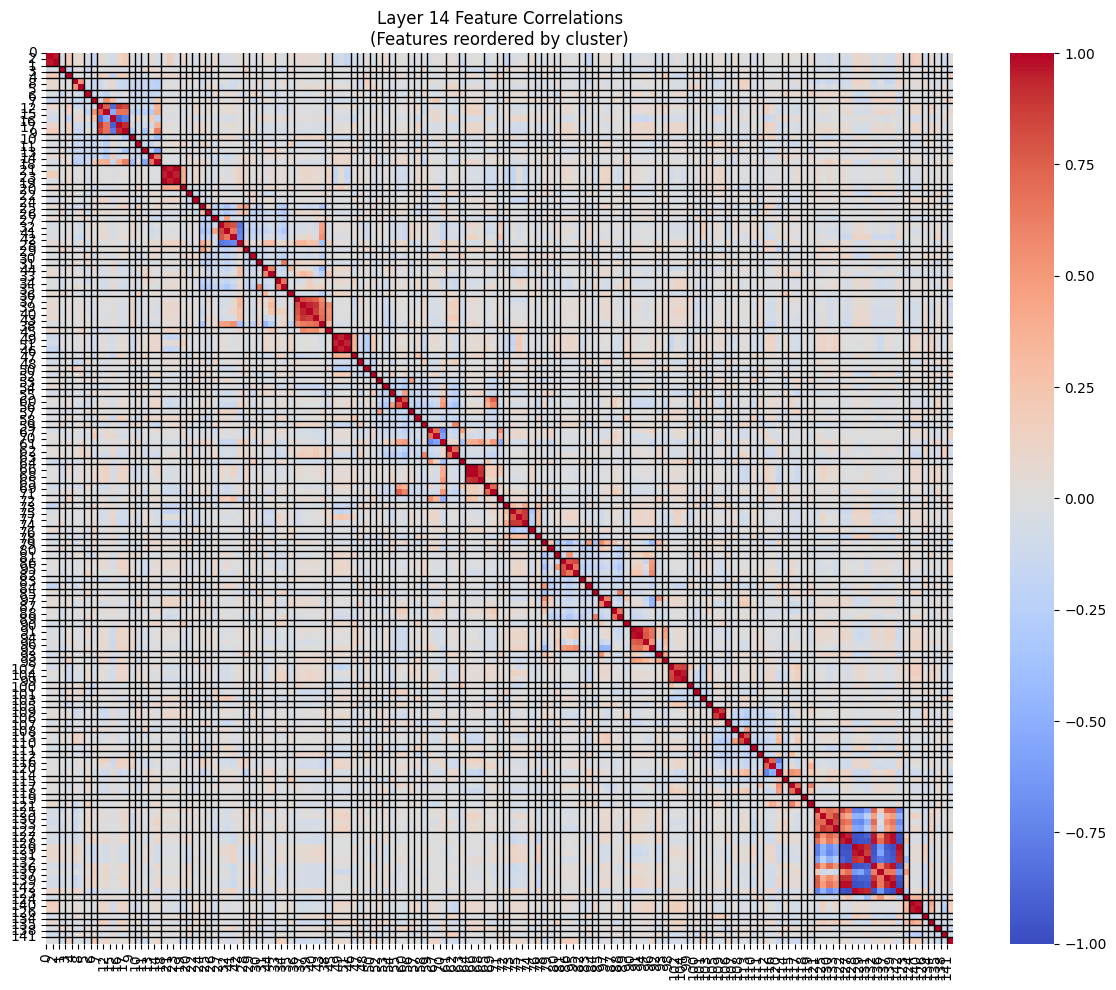


Layer 7 feature ordering:
Cluster 0: features [0]
Cluster 1: features [1]
Cluster 2: features [2]
Cluster 3: features [3, 9]
Cluster 4: features [4]
Cluster 5: features [5]
Cluster 6: features [6, 10]
Cluster 7: features [7]
Cluster 8: features [8]
Cluster 9: features [11]
Cluster 10: features [12]
Cluster 11: features [13]
Cluster 12: features [14]
Cluster 13: features [15, 24]
Cluster 14: features [16]
Cluster 15: features [17]
Cluster 16: features [18, 20, 26]
Cluster 17: features [19]
Cluster 18: features [21]
Cluster 19: features [22]
Cluster 20: features [23, 25]
Cluster 21: features [27]
Cluster 22: features [28]
Cluster 23: features [29, 34]
Cluster 24: features [30, 35]
Cluster 25: features [31]
Cluster 26: features [32, 38]
Cluster 27: features [33]
Cluster 28: features [36]
Cluster 29: features [37]
Cluster 30: features [39]
Cluster 31: features [40]
Cluster 32: features [41]
Cluster 33: features [42]
Cluster 34: features [43, 51]
Cluster 35: features [44]
Cluster 36: featu

In [114]:
def reorder_by_clusters(values, clusters):
    """
    Reorder features so ones in the same cluster are adjacent.
    
    Args:
        values: Tensor of shape [num_samples, num_features]
        clusters: Dict mapping cluster_idx to list of feature indices
    
    Returns:
        reordered_values: Tensor with reordered features
        feature_order: List of original feature indices in new order
        cluster_boundaries: List of indices where clusters end
    """
    # Create ordered list of feature indices
    feature_order = []
    cluster_boundaries = []
    
    for cluster_idx, feature_indices in clusters.items():
        feature_order.extend(feature_indices)
        cluster_boundaries.append(len(feature_order))
    
    # Reorder the features
    reordered_values = values[:, feature_order]
    
    return reordered_values, feature_order, cluster_boundaries

def plot_correlation_matrix_clustered(values, clusters, title):
    """Plot correlation matrix with features ordered by cluster."""
    if values.shape[1] == 1:
        print(f"Skipping correlation plot for {title} - only one feature")
        return
        
    # Reorder features
    reordered_values, feature_order, cluster_boundaries = reorder_by_clusters(values, clusters)
    
    # Calculate correlation matrix
    corr = np.corrcoef(reordered_values.T)
    corr = clean_correlation_matrix(corr)
    
    # Plot
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, cmap='coolwarm', center=0, vmin=-1, vmax=1)
    
    # Add cluster boundary lines
    for boundary in cluster_boundaries[:-1]:
        plt.axhline(y=boundary, color='black', linestyle='-', linewidth=1)
        plt.axvline(x=boundary, color='black', linestyle='-', linewidth=1)
    
    plt.title(f"{title}\n(Features reordered by cluster)")
    
    # Label axes with original feature indices
    plt.xticks(range(len(feature_order)), feature_order, rotation=90)
    plt.yticks(range(len(feature_order)), feature_order, rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    return reordered_values, feature_order, cluster_boundaries

# Plot reordered correlation matrices
print("\nPlotting clustered correlation matrices...")
print("\nLayer 7 clusters:")
layer7_reordered, layer7_order, layer7_bounds = plot_correlation_matrix_clustered(
    layer7_values, layer7_clusters, "Layer 7 Feature Correlations")

print("\nLayer 14 clusters:")
layer14_reordered, layer14_order, layer14_bounds = plot_correlation_matrix_clustered(
    layer14_values, layer14_clusters, "Layer 14 Feature Correlations")

# Print cluster information
print("\nLayer 7 feature ordering:")
current_pos = 0
for i, boundary in enumerate(layer7_bounds):
    features = layer7_order[current_pos:boundary]
    print(f"Cluster {i}: features {features}")
    current_pos = boundary

print("\nLayer 14 feature ordering:")
current_pos = 0
for i, boundary in enumerate(layer14_bounds):
    features = layer14_order[current_pos:boundary]
    print(f"Cluster {i}: features {features}")
    current_pos = boundary


Visualizing cluster-to-cluster correlations:


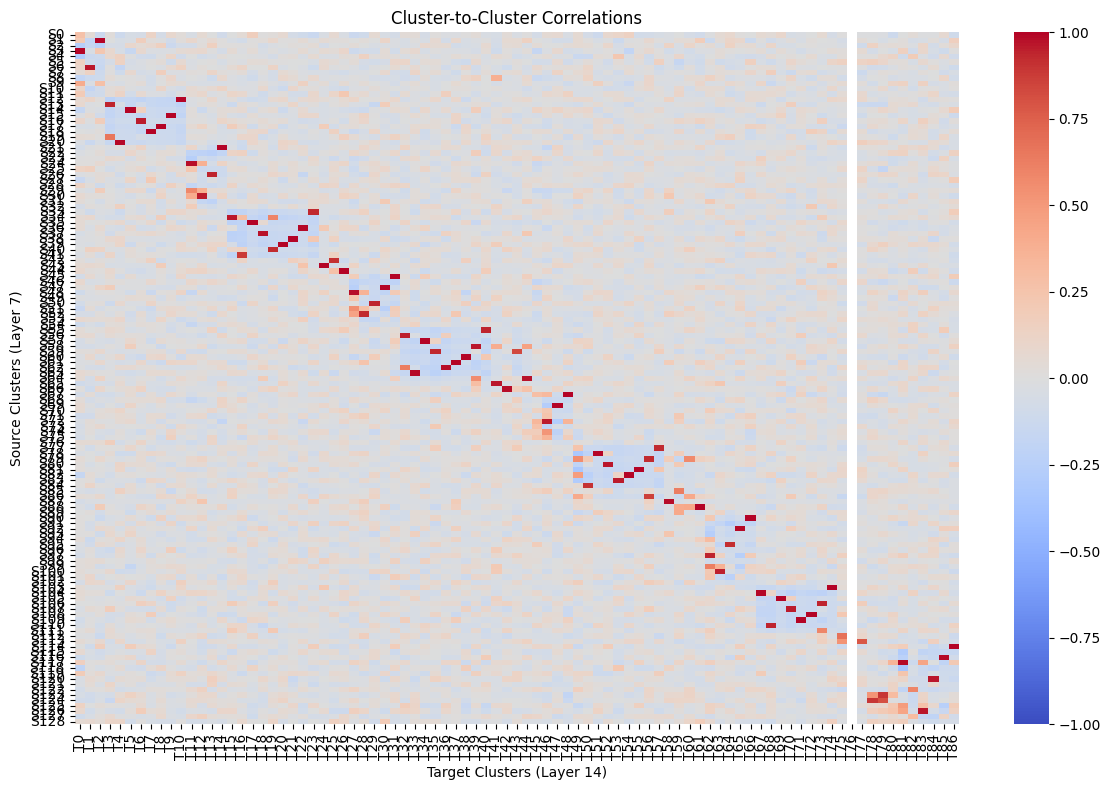


Strongest cluster-to-cluster connectionsf:

Source Cluster 15 -> Target Cluster 9
Correlation: 1.000
Source features: [30, 35]
Target features: [7, 12, 15, 16, 17]

Source Cluster 14 -> Target Cluster 5
Correlation: 1.000
Source features: [46, 48, 53]
Target features: [121, 125, 130, 133]

Source Cluster 1 -> Target Cluster 2
Correlation: 1.000
Source features: [63, 67]
Target features: [122, 127, 128, 129, 131, 132, 136, 137, 139, 142]

Source Cluster 18 -> Target Cluster 7
Correlation: 1.000
Source features: [45, 55]
Target features: [27, 32, 41, 42]

Source Cluster 17 -> Target Cluster 8
Correlation: 1.000
Source features: [148, 154, 157]
Target features: [31, 44]

Source Cluster 44 -> Target Cluster 26
Correlation: 1.000
Source features: [100]
Target features: [135]

Source Cluster 35 -> Target Cluster 17
Correlation: 1.000
Source features: [129]
Target features: [126]

Source Cluster 39 -> Target Cluster 20
Correlation: 1.000
Source features: [99]
Target features: [81, 86, 95]

S

In [108]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class ClusterMapping:
    def __init__(self, source_clusters, target_clusters):
        self.source_clusters = source_clusters
        self.target_clusters = target_clusters
        self.source_to_cluster = {}  # Maps feature idx to cluster idx
        self.target_to_cluster = {}
        
        # Create reverse mappings for easy lookup
        for cluster_idx, features in source_clusters.items():
            for feat_idx in features:
                self.source_to_cluster[feat_idx] = cluster_idx
                
        for cluster_idx, features in target_clusters.items():
            for feat_idx in features:
                self.target_to_cluster[feat_idx] = cluster_idx

    def compute_cluster_means(self, source_values, target_values):
        """Compute mean activations for each cluster."""
        source_means = {}
        target_means = {}
        
        for cluster_idx, features in self.source_clusters.items():
            source_means[cluster_idx] = source_values[:, features].mean(dim=1)
            
        for cluster_idx, features in self.target_clusters.items():
            target_means[cluster_idx] = target_values[:, features].mean(dim=1)
            
        return source_means, target_means

    def analyze_cluster_relationships(self, source_values, target_values):
        """Analyze relationships between source and target clusters."""
        source_means, target_means = self.compute_cluster_means(source_values, target_values)
        
        # Convert to matrices for correlation
        source_matrix = torch.stack([v for v in source_means.values()], dim=1)
        target_matrix = torch.stack([v for v in target_means.values()], dim=1)
        
        # Compute correlation matrix
        correlations = torch.corrcoef(torch.cat([source_matrix, target_matrix], dim=1).T)
        num_source = len(source_means)
        cluster_correlations = correlations[:num_source, num_source:]
        
        return cluster_correlations
    
    def visualize_cluster_mapping(self, cluster_correlations):
        """Visualize the correlations between clusters."""
        plt.figure(figsize=(12, 8))
        sns.heatmap(cluster_correlations.numpy(), 
                   cmap='coolwarm', 
                   center=0,
                   vmin=-1, 
                   vmax=1,
                   xticklabels=[f'T{i}' for i in range(len(self.target_clusters))],
                   yticklabels=[f'S{i}' for i in range(len(self.source_clusters))])
        plt.title('Cluster-to-Cluster Correlations')
        plt.xlabel('Target Clusters (Layer 14)')
        plt.ylabel('Source Clusters (Layer 7)')
        plt.tight_layout()
        plt.show()

    def find_strongest_connections(self, cluster_correlations, threshold=0.3):
        """Find strongest connections between clusters."""
        connections = []
        corr_np = cluster_correlations.numpy()
        
        for source_idx in range(corr_np.shape[0]):
            for target_idx in range(corr_np.shape[1]):
                corr = corr_np[source_idx, target_idx]
                if abs(corr) > threshold:
                    connections.append({
                        'source_cluster': source_idx,
                        'target_cluster': target_idx,
                        'correlation': corr,
                        'source_features': self.source_clusters[source_idx],
                        'target_features': self.target_clusters[target_idx]
                        
                    })
        
        # Sort by absolute correlation
        connections.sort(key=lambda x: abs(x['correlation']), reverse=True)
        return connections

# Create and run the analysis
cluster_mapper = ClusterMapping(layer7_clusters, layer14_clusters)

# Compute and visualize correlations
cluster_correlations = cluster_mapper.analyze_cluster_relationships(layer7_values, layer14_values)
print("\nVisualizing cluster-to-cluster correlations:")
cluster_mapper.visualize_cluster_mapping(cluster_correlations)

# Find and print strongest connections
print("\nStrongest cluster-to-cluster connectionsf:")
connections = cluster_mapper.find_strongest_connections(cluster_correlations, threshold=0.3)
for conn in connections:
    print(f"\nSource Cluster {conn['source_cluster']} -> Target Cluster {conn['target_cluster']}")
    print(f"Correlation: {conn['correlation']:.3f}")
    print(f"Source features: {conn['source_features']}")
    print(f"Target features: {conn['target_features']}")

# Additional Analysis: Feature Importance within Clusters
def analyze_feature_importance(values, clusters):
    """Analyze how important each feature is to its cluster."""
    importances = {}
    
    for cluster_idx, features in clusters.items():
        if len(features) > 1:
            cluster_values = values[:, features]
            # Compute correlation with cluster mean
            cluster_mean = cluster_values.mean(dim=1, keepdim=True)
            correlations = torch.corrcoef(torch.cat([cluster_values, cluster_mean], dim=1).T)
            # Last row contains correlations with mean
            feature_importances = correlations[:-1, -1]
            importances[cluster_idx] = {
                'features': features,
                'importances': feature_importances.tolist()
            }
    
    return importances

print("\nAnalyzing feature importance within clusters:")
print("\nLayer 7 feature importance:")
layer7_importance = analyze_feature_importance(layer7_values, layer7_clusters)
for cluster_idx, data in layer7_importance.items():
    print(f"\nCluster {cluster_idx}:")
    for feat, imp in zip(data['features'], data['importances']):
        print(f"Feature {feat}: {imp:.3f}")

print("\nLayer 14 feature importance:")
layer14_importance = analyze_feature_importance(layer14_values, layer14_clusters)
for cluster_idx, data in layer14_importance.items():
    print(f"\nCluster {cluster_idx}:")
    for feat, imp in zip(data['features'], data['importances']):
        print(f"Feature {feat}: {imp:.3f}")

In [109]:
def analyze_feature_relationships(values1, values2, correlation_threshold=0.3):
    """
    Analyze direct feature-to-feature relationships between two SAE layers.
    
    Args:
        values1: Tensor of shape [num_samples, num_features1]
        values2: Tensor of shape [num_samples, num_features2]
        correlation_threshold: Minimum absolute correlation to consider
    """
    # Compute correlation matrix between all features
    joint_values = torch.cat([values1, values2], dim=1)
    correlations = torch.corrcoef(joint_values.T)
    
    # Extract cross-correlations between layers
    num_features1 = values1.shape[1]
    cross_correlations = correlations[:num_features1, num_features1:]
    
    # Plot full correlation matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(cross_correlations.numpy(), 
                cmap='coolwarm', 
                center=0,
                vmin=-1, 
                vmax=1,
                xticklabels=list(range(values2.shape[1])),
                yticklabels=list(range(values1.shape[1])))
    plt.title('Feature-to-Feature Correlations')
    plt.xlabel('Target Features')
    plt.ylabel('Source Features')
    plt.tight_layout()
    plt.show()
    
    # Find strong connections
    strong_connections = []
    for i in range(cross_correlations.shape[0]):
        for j in range(cross_correlations.shape[1]):
            corr = cross_correlations[i, j].item()
            if abs(corr) > correlation_threshold:
                strong_connections.append({
                    'source_feature': i,
                    'target_feature': j,
                    'correlation': corr
                })
    
    # Sort by absolute correlation
    strong_connections.sort(key=lambda x: abs(x['correlation']), reverse=True)
    
    return cross_correlations, strong_connections

def print_feature_connections(connections):
    """Print feature connections in a readable format."""
    print("\nStrong feature-to-feature connections:")
    for conn in connections:
        print(f"Source Feature {conn['source_feature']} → Target Feature {conn['target_feature']}: {conn['correlation']:.3f}")

def find_feature_groups(cross_correlations, correlation_threshold=0.3):
    """
    Find groups of related features across layers using connectivity patterns.
    
    Returns groups where source features and target features are related through
    strong correlations.
    """
    from scipy.sparse.csgraph import connected_components
    from scipy.sparse import csr_matrix
    
    # Create adjacency matrix based on strong correlations
    abs_corr = torch.abs(cross_correlations)
    adj_matrix = (abs_corr > correlation_threshold).numpy()
    
    # Convert to sparse matrix
    sparse_adj = csr_matrix(adj_matrix)
    
    # Find connected components
    n_components, labels = connected_components(sparse_adj, directed=False)
    
    # Group features by component
    groups = {}
    source_shape = cross_correlations.shape[0]
    target_shape = cross_correlations.shape[1]
    
    for i in range(n_components):
        source_features = [j for j in range(source_shape) if labels[j] == i]
        target_features = [j for j in range(target_shape) if labels[j + source_shape] == i]
        if source_features or target_features:  # Only include non-empty groups
            groups[i] = {
                'source_features': source_features,
                'target_features': target_features
            }
    
    return groups

In [110]:
def compute_cluster_loss(values, clusters):
    """
    Compute information loss from using cluster representations.
    
    For each cluster:
    1. Compute cluster mean
    2. Use that mean to reconstruct each feature in the cluster
    3. Compute reconstruction error (MSE)
    4. Also compute R² score to show explained variance
    
    Args:
        values: Tensor of shape [num_samples, num_features]
        clusters: Dict mapping cluster_idx to list of feature indices
    
    Returns:
        Dict containing loss metrics for each cluster and overall
    """
    total_variance = torch.var(values, dim=0).sum().item()
    total_features = values.shape[1]
    
    cluster_metrics = {}
    total_mse = 0
    total_weighted_mse = 0
    
    for cluster_idx, feature_indices in clusters.items():
        cluster_values = values[:, feature_indices]
        
        # Skip if cluster has only one feature
        if len(feature_indices) == 1:
            cluster_metrics[cluster_idx] = {
                'mse': 0.0,
                'r2': 1.0,
                'explained_variance': 1.0,
                'num_features': 1
            }
            continue
        
        # Compute cluster mean
        cluster_mean = cluster_values.mean(dim=1, keepdim=True)
        
        # Reconstruct using cluster mean
        reconstructed = cluster_mean.expand(-1, len(feature_indices))
        
        # Compute MSE
        mse = F.mse_loss(reconstructed, cluster_values).item()
        
        # Compute R² score
        variance = torch.var(cluster_values, dim=0).sum().item()
        r2 = 1 - (mse * len(feature_indices)) / variance if variance != 0 else 1.0
        
        # Store metrics
        cluster_metrics[cluster_idx] = {
        'mse': mse,
        'r2': r2,
        'explained_variance': 1 - mse/variance if variance != 0 else 1.0,
        'num_features': len(feature_indices),
        'feature_indices': feature_indices  # Add this line
        }
        
        total_mse += mse * len(feature_indices)
        total_weighted_mse += mse * (len(feature_indices) / total_features)

    # Compute overall metrics
    overall_metrics = {
        'total_mse': total_mse,
        'avg_mse_per_feature': total_weighted_mse,
        'total_variance': total_variance,
        'explained_variance_ratio': 1 - total_weighted_mse/total_variance if total_variance != 0 else 1.0
    }
    
    return {
        'cluster_metrics': cluster_metrics,
        'overall_metrics': overall_metrics
    }

def print_cluster_loss_summary(loss_metrics, layer_data):
    """Print a readable summary of cluster loss metrics with latent IDs."""
    original_indices = layer_data['indices']  # List of (seq_pos, feature_idx) tuples
    feature_to_id = {i: idx[1] for i, idx in enumerate(original_indices)}
    
    print("\nCluster Loss Analysis:")
    print("\nPer-Cluster Metrics:")
    for cluster_idx, metrics in loss_metrics['cluster_metrics'].items():
        # Get latent IDs for this cluster
        feature_indices = metrics['feature_indices']
        latent_ids = [feature_to_id[idx] for idx in feature_indices]
        
        print(f"\nCluster {cluster_idx} ({metrics['num_features']} features):")
        print(f"  Latent IDs: {latent_ids}")
        print(f"  MSE: {metrics['mse']:.4f}")
        print(f"  R² Score: {metrics['r2']:.4f}")
        print(f"  Explained Variance: {metrics['explained_variance']:.4f}")
    
    print("\nOverall Metrics:")
    overall = loss_metrics['overall_metrics']
    print(f"Total MSE: {overall['total_mse']:.4f}")
    print(f"Average MSE per feature: {overall['avg_mse_per_feature']:.4f}")
    print(f"Total Data Variance: {overall['total_variance']:.4f}")
    print(f"Overall Explained Variance Ratio: {overall['explained_variance_ratio']:.4f}")



# cross cluster info loss

def compute_cross_layer_prediction_loss(source_values, source_clusters, target_values):
    """
    Compute how well we can predict target layer activations using source layer clusters.
    
    For each source cluster:
    1. Get its mean activation pattern
    2. Try to predict each target feature using a linear combination of source cluster means
    3. Compute prediction error and explained variance
    
    Args:
        source_values: Tensor of shape [num_samples, num_source_features]
        source_clusters: Dict mapping cluster_idx to list of feature indices
        target_values: Tensor of shape [num_samples, num_target_features]
    """
    # Standardize the values
    source_values = (source_values - source_values.mean(dim=0)) / (source_values.std(dim=0) + 1e-8)
    target_values = (target_values - target_values.mean(dim=0)) / (target_values.std(dim=0) + 1e-8)
    
    # Get cluster means for source layer
    cluster_means = []
    for cluster_idx, feature_indices in source_clusters.items():
        cluster_values = source_values[:, feature_indices]
        mean = cluster_values.mean(dim=1)
        cluster_means.append(mean)
    
    # Stack cluster means into a matrix
    X = torch.stack(cluster_means, dim=1)  # [num_samples, num_clusters]
    
    # Add a constant term (intercept)
    X = torch.cat([X, torch.ones_like(X[:, :1])], dim=1)
    
    # For each target feature, compute best linear prediction from source clusters
    num_target_features = target_values.shape[1]
    prediction_metrics = []
    
    for i in range(num_target_features):
        y = target_values[:, i]
        
        # Compute basic statistics
        y_mean = y.mean()
        total_ss = ((y - y_mean) ** 2).sum()
        
        try:
            # Solve least squares: y = Xb + e
            coeffs = torch.linalg.lstsq(X, y.unsqueeze(1)).solution
            
            # Make prediction
            y_pred = (X @ coeffs).squeeze()
            
            # Compute residual sum of squares
            residual_ss = ((y - y_pred) ** 2).sum()
            
            # Compute R²
            r2 = 1 - (residual_ss / total_ss)
            r2 = max(min(r2.item(), 1.0), 0.0)  # Clip to [0,1]
            
            # Compute MSE
            mse = F.mse_loss(y_pred, y).item()
            
        except:
            # In case of numerical issues
            r2 = 0.0
            mse = ((y - y_mean) ** 2).mean().item()
        
        prediction_metrics.append({
            'target_feature': i,
            'mse': mse,
            'r2': r2
        })
    
    # Compute overall metrics
    total_mse = sum(m['mse'] for m in prediction_metrics)
    avg_r2 = sum(m['r2'] for m in prediction_metrics) / len(prediction_metrics)
    
    overall_metrics = {
        'total_mse': total_mse,
        'avg_mse_per_feature': total_mse / num_target_features,
        'avg_r2': avg_r2,
        'num_source_clusters': len(source_clusters),
        'num_target_features': num_target_features
    }
    
    return {
        'feature_metrics': prediction_metrics,
        'overall_metrics': overall_metrics
    }

def print_cross_layer_prediction_summary(prediction_metrics, source_data, target_data):
    """Print a readable summary of cross-layer prediction metrics with latent IDs."""
    # Create mappings from feature index to latent ID
    source_indices = source_data['indices']
    target_indices = target_data['indices']
    source_to_id = {i: idx[1] for i, idx in enumerate(source_indices)}
    target_to_id = {i: idx[1] for i, idx in enumerate(target_indices)}
    
    print("\nCross-Layer Prediction Analysis:")
    
    print("\nPer-Feature Metrics:")
    feature_metrics = prediction_metrics['feature_metrics']
    # Sort features by R² score
    sorted_metrics = sorted(feature_metrics, key=lambda x: x['r2'], reverse=True)
    
    print("\nTop 5 best-predicted features:")
    for m in sorted_metrics[:5]:
        target_id = target_to_id[m['target_feature']]
        print(f"Target Feature {m['target_feature']} (Latent ID {target_id}):")
        print(f"  R² Score: {m['r2']:.4f}")
        print(f"  MSE: {m['mse']:.4f}")
    
    if len(sorted_metrics) > 5:
        print("\nBottom 5 worst-predicted features:")
        for m in sorted_metrics[-5:]:
            target_id = target_to_id[m['target_feature']]
            print(f"Target Feature {m['target_feature']} (Latent ID {target_id}):")
            print(f"  R² Score: {m['r2']:.4f}")
            print(f"  MSE: {m['mse']:.4f}")
    
    print("\nOverall Metrics:")
    overall = prediction_metrics['overall_metrics']
    print(f"Using {overall['num_source_clusters']} source clusters to predict {overall['num_target_features']} target features")
    print(f"Total MSE: {overall['total_mse']:.4f}")
    print(f"Average MSE per feature: {overall['avg_mse_per_feature']:.4f}")
    print(f"Average R² across features: {overall['avg_r2']:.4f}")


def print_cluster_info(clusters, layer_data):
    """Print cluster information with latent IDs."""
    original_indices = layer_data['indices']
    feature_to_id = {i: idx[1] for i, idx in enumerate(original_indices)}
    
    for cluster_idx, feature_indices in clusters.items():
        latent_ids = [feature_to_id[idx] for idx in feature_indices]
        print(f"Cluster {cluster_idx}: {len(feature_indices)} features")
        print(f"  Feature indices: {feature_indices}")
        print(f"  Latent IDs: {latent_ids}\n")



Analyzing SAE 0 → SAE 1
Correlation threshold: 0.3, Connection threshold: 0.3

Data shapes:
Layer 0 values shape: torch.Size([256, 167])
Layer 1 values shape: torch.Size([256, 143])

Analyzing layer 0...
Found 114 clusters in layer 0
Cluster 93: 1 features [0]
Cluster 110: 1 features [1]
Cluster 2: 2 features [2, 7]
Cluster 28: 2 features [3, 9]
Cluster 107: 1 features [4]
Cluster 82: 1 features [5]
Cluster 44: 2 features [6, 10]
Cluster 1: 2 features [8, 86]
Cluster 76: 1 features [11]
Cluster 72: 1 features [12]
Cluster 102: 1 features [13]
Cluster 92: 1 features [14]
Cluster 16: 2 features [15, 24]
Cluster 98: 1 features [16]
Cluster 74: 1 features [17]
Cluster 56: 3 features [18, 20, 26]
Cluster 79: 1 features [19]
Cluster 66: 1 features [21]
Cluster 103: 1 features [22]
Cluster 29: 2 features [23, 25]
Cluster 62: 1 features [27]
Cluster 105: 1 features [28]
Cluster 87: 2 features [29, 34]
Cluster 3: 3 features [30, 35, 37]
Cluster 77: 1 features [31]
Cluster 15: 2 features [32, 3

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


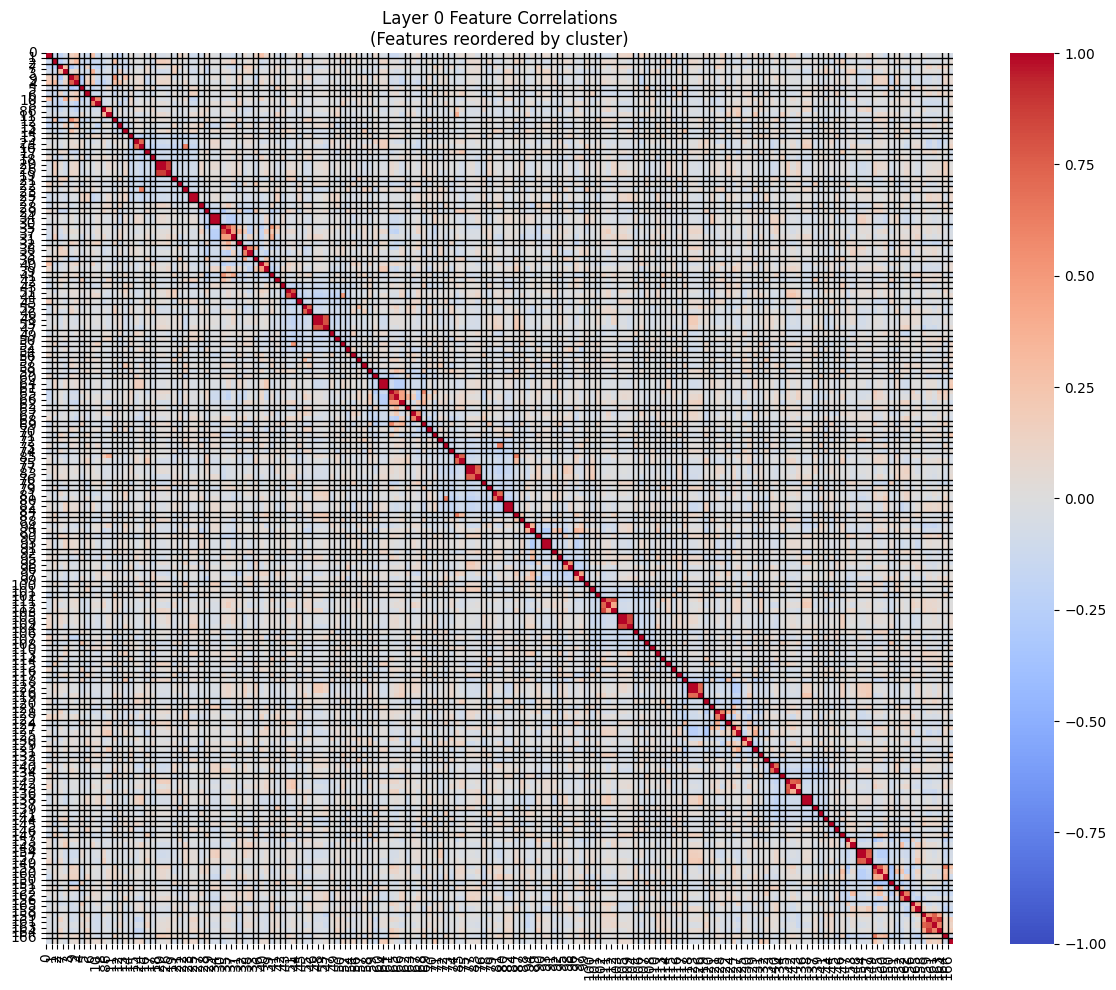


Layer 1 clusters:


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


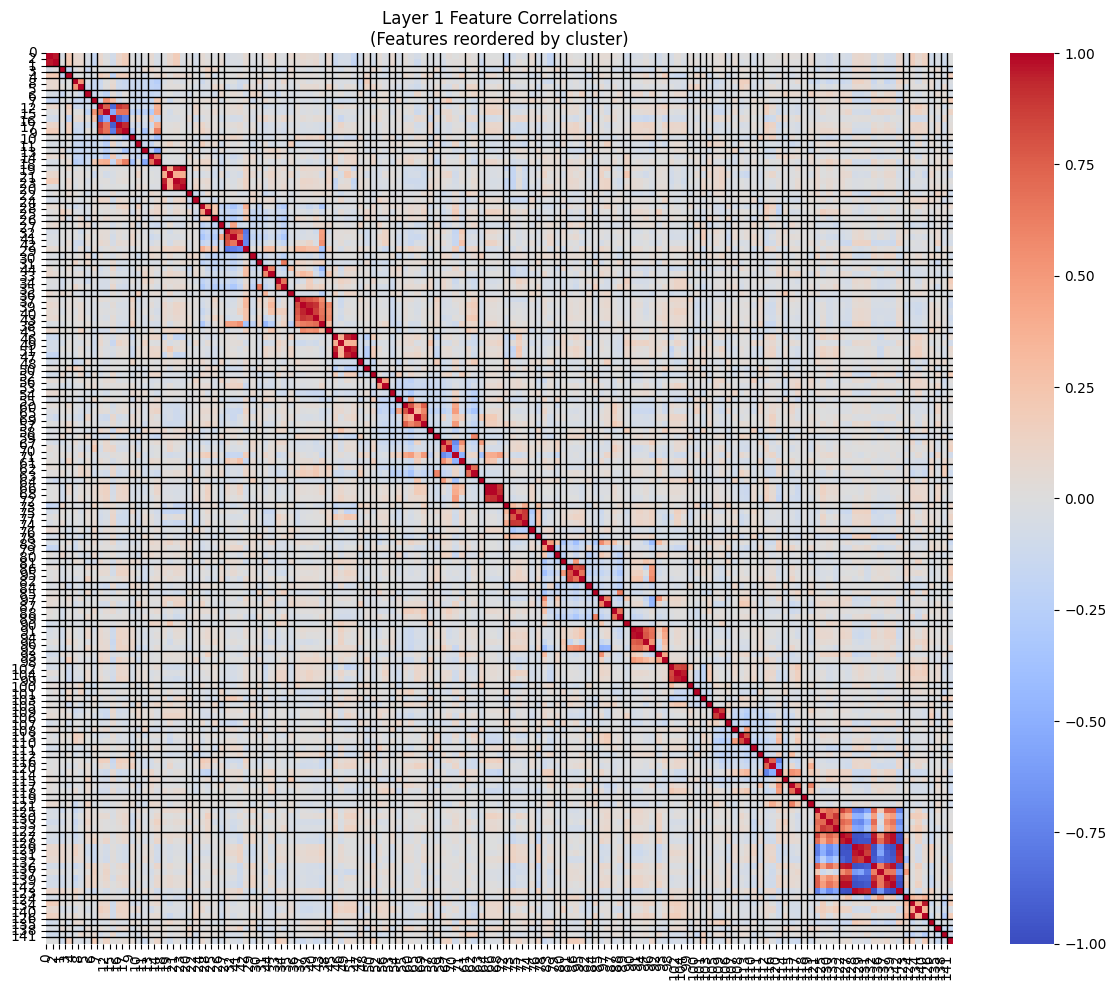


Analyzing cluster mappings...

Visualizing cluster-to-cluster correlations:


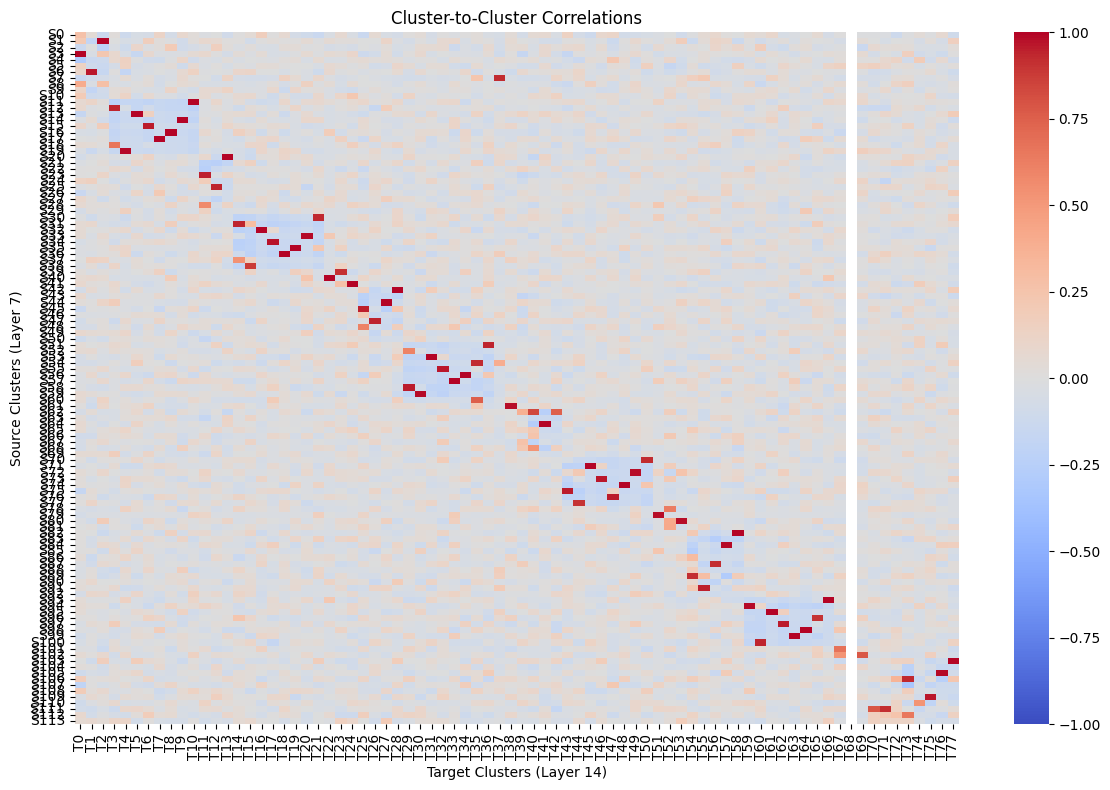


Strongest cluster-to-cluster connections (threshold = 0.3):

Source Cluster 14 -> Target Cluster 9
Correlation: 1.000
Source features: [46, 48, 53]
Target features: [112, 116, 120]

Source Cluster 13 -> Target Cluster 5
Correlation: 1.000
Source features: [135, 142, 143]
Target features: [92, 93]

Source Cluster 1 -> Target Cluster 2
Correlation: 1.000
Source features: [8, 86]
Target features: [18, 19, 21, 23]

Source Cluster 17 -> Target Cluster 7
Correlation: 1.000
Source features: [148, 154, 157]
Target features: [78, 83]

Source Cluster 16 -> Target Cluster 8
Correlation: 1.000
Source features: [15, 24]
Target features: [55, 60, 65, 69]

Source Cluster 41 -> Target Cluster 24
Correlation: 1.000
Source features: [151]
Target features: [87, 88]

Source Cluster 32 -> Target Cluster 16
Correlation: 1.000
Source features: [136, 138]
Target features: [4, 8]

Source Cluster 36 -> Target Cluster 18
Correlation: 1.000
Source features: [132]
Target features: [85, 97]

Source Cluster 53 -> T

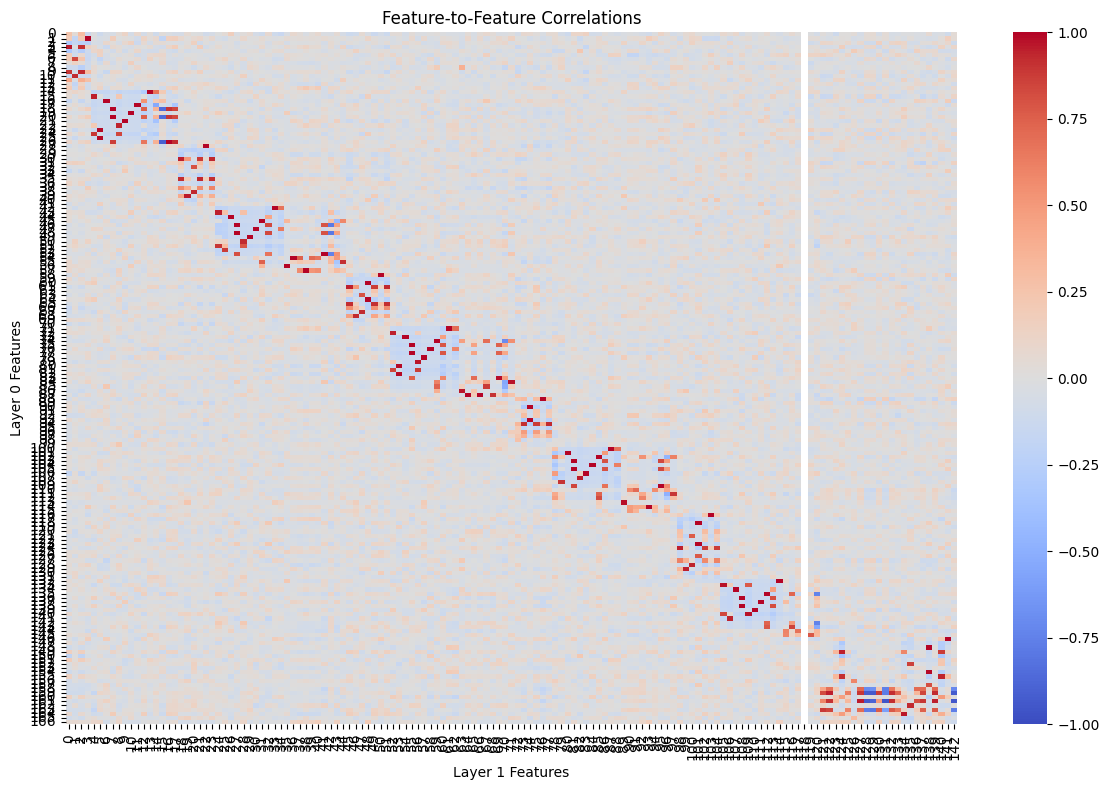


Strong feature-to-feature connections:
Source Feature 14 → Target Feature 13: 1.000
Source Feature 17 → Target Feature 11: 1.000
Source Feature 16 → Target Feature 6: 1.000
Source Feature 1 → Target Feature 3: 1.000
Source Feature 21 → Target Feature 9: 1.000
Source Feature 19 → Target Feature 10: 1.000
Source Feature 45 → Target Feature 31: 1.000
Source Feature 57 → Target Feature 38: 1.000
Source Feature 44 → Target Feature 26: 1.000
Source Feature 49 → Target Feature 29: 1.000
Source Feature 73 → Target Feature 54: 1.000
Source Feature 134 → Target Feature 107: 1.000
Source Feature 71 → Target Feature 61: 1.000
Source Feature 56 → Target Feature 35: 1.000
Source Feature 135 → Target Feature 112: 1.000
Source Feature 100 → Target Feature 87: 1.000
Source Feature 20 → Target Feature 7: 1.000
Source Feature 102 → Target Feature 85: 1.000
Source Feature 78 → Target Feature 57: 1.000
Source Feature 74 → Target Feature 59: 1.000
Source Feature 139 → Target Feature 110: 1.000
Source Featu

In [112]:
def analyze_sae_pair(sae_idx1, sae_idx2, correlation_threshold=0.5, connection_threshold=0.3, 
                    feature_correlation_threshold=0.3, masked_activations_path="masked_activations.pt"):
    """
    Comprehensive analysis of the relationship between two SAE layers.
    
    Args:
        sae_idx1 (int): Index of first SAE (0-3 corresponding to layers 7,14,21,40)
        sae_idx2 (int): Index of second SAE 
        correlation_threshold (float): Threshold for clustering features (0-1)
        connection_threshold (float): Threshold for showing cluster connections (0-1)
        feature_correlation_threshold (float): Threshold for direct feature connections (0-1)
        masked_activations_path (str): Path to saved masked activations
        
    Returns:
        dict: Analysis results including clusters, correlations, and mappings
    """
    import torch
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.preprocessing import StandardScaler
    from sklearn.cluster import AgglomerativeClustering
    from scipy.sparse.csgraph import connected_components
    from scipy.sparse import csr_matrix
    
    # Load masked activations
    print(f"\nAnalyzing SAE {sae_idx1} → SAE {sae_idx2}")
    print(f"Correlation threshold: {correlation_threshold}, Connection threshold: {connection_threshold}")
    
    layer_names = {
        0: "blocks.7.hook_resid_post",
        1: "blocks.14.hook_resid_post",
        2: "blocks.21.hook_resid_post",
        3: "blocks.40.hook_resid_post"
    }
    
    masked_activations = torch.load(masked_activations_path)
    
    # Get data for both layers
    layer1_data = masked_activations[layer_names[sae_idx1]]
    layer2_data = masked_activations[layer_names[sae_idx2]]
    
    layer1_values = layer1_data['values'].cpu()
    layer2_values = layer2_data['values'].cpu()
    
    print("\nData shapes:")
    print(f"Layer {sae_idx1} values shape:", layer1_values.shape)
    print(f"Layer {sae_idx2} values shape:", layer2_values.shape)
    
    # Initialize mappers
    sae1_mapper = InterpretableSAEMapping(correlation_threshold=correlation_threshold)
    sae2_mapper = InterpretableSAEMapping(correlation_threshold=correlation_threshold)
    
    # Find correlated features
    print(f"\nAnalyzing layer {sae_idx1}...")
    layer1_clusters = sae1_mapper.find_correlated_features(layer1_values)
    print(f"Found {len(layer1_clusters)} clusters in layer {sae_idx1}")
    for i, cluster in layer1_clusters.items():
        print(f"Cluster {i}: {len(cluster)} features {cluster}")
    
    print(f"\nAnalyzing layer {sae_idx2}...")
    layer2_clusters = sae2_mapper.find_correlated_features(layer2_values)
    print(f"Found {len(layer2_clusters)} clusters in layer {sae_idx2}")
    for i, cluster in layer2_clusters.items():
        print(f"Cluster {i}: {len(cluster)} features {cluster}")
    
    # Plot clustered correlation matrices
    print("\nPlotting correlation matrices...")
    print(f"\nLayer {sae_idx1} clusters:")
    layer1_reordered, layer1_order, layer1_bounds = plot_correlation_matrix_clustered(
        layer1_values, layer1_clusters, f"Layer {sae_idx1} Feature Correlations")
    
    print(f"\nLayer {sae_idx2} clusters:")
    layer2_reordered, layer2_order, layer2_bounds = plot_correlation_matrix_clustered(
        layer2_values, layer2_clusters, f"Layer {sae_idx2} Feature Correlations")
    
    # Analyze cluster mappings
    print("\nAnalyzing cluster mappings...")
    cluster_mapper = ClusterMapping(layer1_clusters, layer2_clusters)
    cluster_correlations = cluster_mapper.analyze_cluster_relationships(layer1_values, layer2_values)
    
    print("\nVisualizing cluster-to-cluster correlations:")
    cluster_mapper.visualize_cluster_mapping(cluster_correlations)
    
    # Find and print strongest cluster connections
    print(f"\nStrongest cluster-to-cluster connections (threshold = {connection_threshold}):")
    connections = cluster_mapper.find_strongest_connections(cluster_correlations, 
                                                         threshold=connection_threshold)
    
    for conn in connections:
        print(f"\nSource Cluster {conn['source_cluster']} -> Target Cluster {conn['target_cluster']}")
        print(f"Correlation: {conn['correlation']:.3f}")
        print(f"Source features: {conn['source_features']}")
        print(f"Target features: {conn['target_features']}")
    
    # Feature importance analysis
    print("\nAnalyzing feature importance within clusters:")
    print(f"\nLayer {sae_idx1} feature importance:")
    layer1_importance = analyze_feature_importance(layer1_values, layer1_clusters)
    for cluster_idx, data in layer1_importance.items():
        print(f"\nCluster {cluster_idx}:")
        for feat, imp in zip(data['features'], data['importances']):
            print(f"Feature {feat}: {imp:.3f}")
    
    print(f"\nLayer {sae_idx2} feature importance:")
    layer2_importance = analyze_feature_importance(layer2_values, layer2_clusters)
    for cluster_idx, data in layer2_importance.items():
        print(f"\nCluster {cluster_idx}:")
        for feat, imp in zip(data['features'], data['importances']):
            print(f"Feature {feat}: {imp:.3f}")
    
    # Direct feature-to-feature analysis
    print("\nAnalyzing direct feature relationships...")
    # Compute correlation matrix between all features
    joint_values = torch.cat([layer1_values, layer2_values], dim=1)
    correlations = torch.corrcoef(joint_values.T)
    
    # Extract cross-correlations between layers
    num_features1 = layer1_values.shape[1]
    cross_correlations = correlations[:num_features1, num_features1:]
    
    # Plot feature correlation matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(cross_correlations.numpy(), 
                cmap='coolwarm', 
                center=0,
                vmin=-1, 
                vmax=1,
                xticklabels=list(range(layer2_values.shape[1])),
                yticklabels=list(range(layer1_values.shape[1])))
    plt.title('Feature-to-Feature Correlations')
    plt.xlabel(f'Layer {sae_idx2} Features')
    plt.ylabel(f'Layer {sae_idx1} Features')
    plt.tight_layout()
    plt.show()
    
    # Find strong feature connections
    strong_connections = []
    for i in range(cross_correlations.shape[0]):
        for j in range(cross_correlations.shape[1]):
            corr = cross_correlations[i, j].item()
            if abs(corr) > feature_correlation_threshold:
                strong_connections.append({
                    'source_feature': i,
                    'target_feature': j,
                    'correlation': corr
                })
    
    # Sort by absolute correlation
    strong_connections.sort(key=lambda x: abs(x['correlation']), reverse=True)
    
    # Print feature connections
    print("\nStrong feature-to-feature connections:")
    for conn in strong_connections:
        print(f"Source Feature {conn['source_feature']} → Target Feature {conn['target_feature']}: {conn['correlation']:.3f}")
    
    # Find feature groups
    print("\nAnalyzing feature groups across layers...")
    abs_corr = torch.abs(cross_correlations)
    
    # Create square adjacency matrix
    n_source = cross_correlations.shape[0]
    n_target = cross_correlations.shape[1]
    n_total = n_source + n_target
    
    # Create full adjacency matrix
    full_adj = torch.zeros((n_total, n_total))
    # Fill in cross-correlations
    full_adj[:n_source, n_source:] = abs_corr
    full_adj[n_source:, :n_source] = abs_corr.T
    
    # Create adjacency based on threshold
    adj_matrix = (full_adj > feature_correlation_threshold).cpu().numpy()
    sparse_adj = csr_matrix(adj_matrix)
    
    # Find connected components
    n_components, labels = connected_components(sparse_adj, directed=False)
    
    # Group features by component
    feature_groups = {}
    for i in range(n_components):
        source_features = [j for j in range(n_source) if labels[j] == i]
        target_features = [j for j in range(n_source, n_total) if labels[j] == i]
        target_features = [j - n_source for j in target_features]  # Adjust indices
        
        if source_features or target_features:  # Only include non-empty groups
            feature_groups[i] = {
                'source_features': source_features,
                'target_features': target_features
            }
    
    print("\nFeature groups across layers:")
    for group_idx, group in feature_groups.items():
        if group['source_features'] or group['target_features']:
            print(f"\nGroup {group_idx}:")
            print(f"Source features: {group['source_features']}")
            print(f"Target features: {group['target_features']}")

    # Add loss analysis for both layers
    # print("\nComputing information loss from clustering...")
    # layer1_loss = compute_cluster_loss(layer1_values, layer1_clusters)
    # print(f"\nLayer {sae_idx1} Loss Metrics:")
    # print_cluster_loss_summary(layer1_loss, layer1_data)
    
    # layer2_loss = compute_cluster_loss(layer2_values, layer2_clusters)
    # print(f"\nLayer {sae_idx2} Loss Metrics:")
    # print_cluster_loss_summary(layer2_loss, layer2_data)

    # Add cross-layer prediction analysis
    # print("\nAnalyzing cross-layer prediction...")
    # cross_layer_metrics = compute_cross_layer_prediction_loss(
    #     layer1_values, layer1_clusters, layer2_values)
    # print_cross_layer_prediction_summary(cross_layer_metrics)
    

    # # Print cluster information with latent IDs
    # print(f"\nLayer {sae_idx1} Clusters:")
    # print_cluster_info(layer1_clusters, layer1_data)
    
    # print(f"\nLayer {sae_idx2} Clusters:")
    # print_cluster_info(layer2_clusters, layer2_data)
    
    # # Use updated print functions
    # print(f"\nLayer {sae_idx1} Loss Metrics:")
    # print_cluster_loss_summary(layer1_loss, layer1_data)
    
    # print(f"\nLayer {sae_idx2} Loss Metrics:")
    # print_cluster_loss_summary(layer2_loss, layer2_data)
    
    print("\nAnalyzing cross-layer prediction...")
    cross_layer_metrics = compute_cross_layer_prediction_loss(
        layer1_values, layer1_clusters, layer2_values)
    print_cross_layer_prediction_summary(cross_layer_metrics, layer1_data, layer2_data)
    # Add to returned results
    # results['cross_layer_prediction'] = cross_layer_metrics

    
    # # Add to returned results
    # results['layer1']['loss_metrics'] = layer1_loss
    # results['layer2']['loss_metrics'] = layer2_loss
    
    # return results


# Example usage:
results = analyze_sae_pair(0, 1, correlation_threshold=0.3, connection_threshold=0.3, feature_correlation_threshold=0.3)

# Cleaned Cluster Circuits

Loading data...
Data shapes:
blocks.7.hook_resid_post: torch.Size([256, 167])
blocks.14.hook_resid_post: torch.Size([256, 143])

blocks.7.hook_resid_post clusters found: 114
blocks.14.hook_resid_post clusters found: 78


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


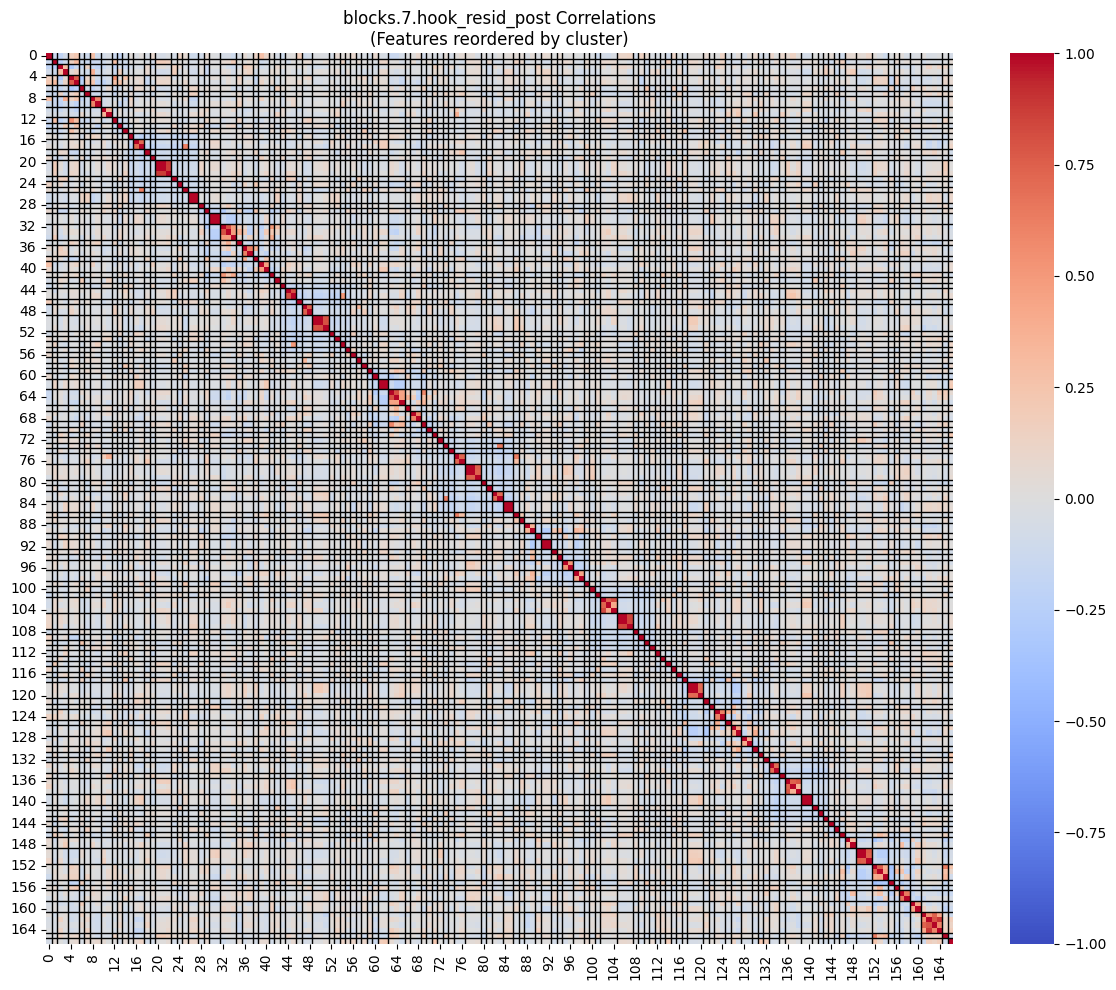

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


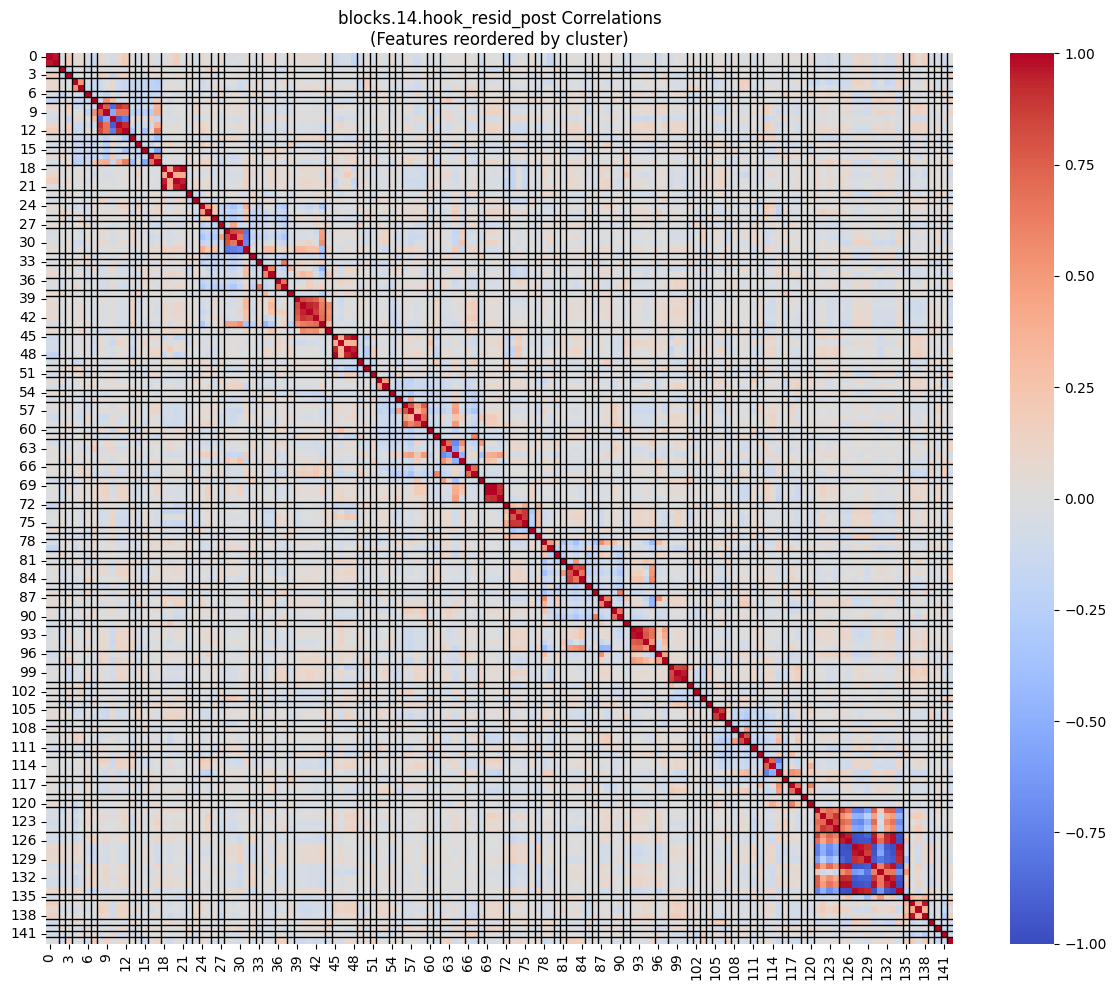

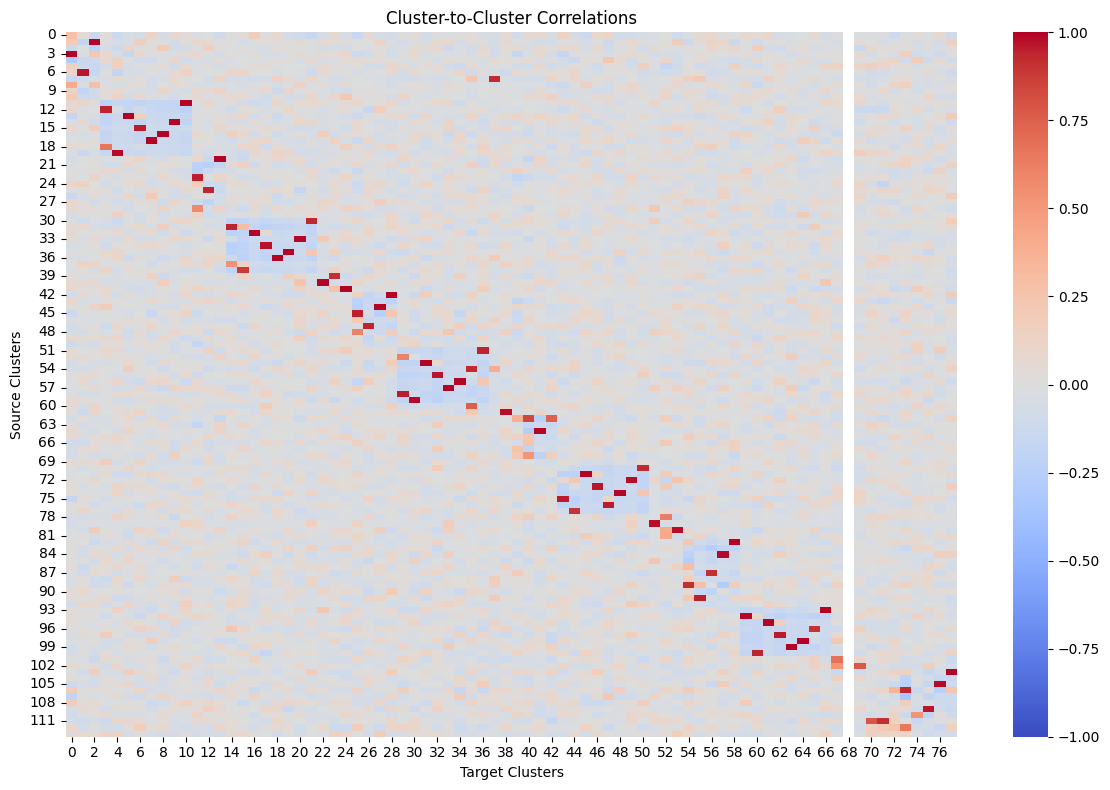


Strongest cluster-to-cluster connections:

Source Cluster 14 -> Target Cluster 9
Correlation: 1.000
Source features: ['46(LID:9299)', '48(LID:9938)', '53(LID:4094)']
Target features: ['112(LID:11578)', '116(LID:8321)', '120(LID:13170)']

Source Cluster 13 -> Target Cluster 5
Correlation: 1.000
Source features: ['135(LID:5337)', '142(LID:5311)', '143(LID:7857)']
Target features: ['92(LID:8321)', '93(LID:8734)']

Source Cluster 1 -> Target Cluster 2
Correlation: 1.000
Source features: ['8(LID:6342)', '86(LID:9046)']
Target features: ['18(LID:3751)', '19(LID:10813)', '21(LID:15305)', '23(LID:15305)']

Source Cluster 17 -> Target Cluster 7
Correlation: 1.000
Source features: ['148(LID:2846)', '154(LID:6342)', '157(LID:10599)']
Target features: ['78(LID:534)', '83(LID:7560)']

Source Cluster 16 -> Target Cluster 8
Correlation: 1.000
Source features: ['15(LID:2498)', '24(LID:15041)']
Target features: ['55(LID:4093)', '60(LID:12405)', '65(LID:3742)', '69(LID:10080)']

Source Cluster 41 -> Ta

In [113]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from torch.nn import functional as F
from scipy.sparse.csgraph import connected_components
from scipy.sparse import csr_matrix


def clean_correlation_matrix(corr_matrix: np.ndarray) -> np.ndarray:
    """
    Clean correlation matrix by ensuring no NaNs, symmetry, and diagonal = 1.
    Handles even the 1D case gracefully.
    """
    if len(corr_matrix.shape) == 1 or corr_matrix.shape[0] == 1:
        return np.array([[1.0]])
    corr_matrix = np.nan_to_num(corr_matrix, 0)
    corr_matrix = (corr_matrix + corr_matrix.T) / 2
    np.fill_diagonal(corr_matrix, 1)
    return corr_matrix


def plot_correlation_matrix(values: torch.Tensor, title: str) -> None:
    """Plot the correlation matrix of given values."""
    if values.shape[1] == 1:
        print(f"Skipping correlation plot for {title} - only one feature")
        return
    corr = np.corrcoef(values.T)
    corr = clean_correlation_matrix(corr)
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, cmap='coolwarm', center=0, vmin=-1, vmax=1)
    plt.title(title)
    plt.show()


def reorder_by_clusters(values: torch.Tensor, clusters: dict) -> (torch.Tensor, list, list):
    """
    Reorder features so that those in the same cluster are adjacent.
    Returns:
        reordered_values: Tensor with reordered features
        feature_order: Original feature indices in new order
        cluster_boundaries: Indices where clusters end
    """
    feature_order = []
    cluster_boundaries = []
    for cluster_idx, feature_indices in clusters.items():
        feature_order.extend(feature_indices)
        cluster_boundaries.append(len(feature_order))
    reordered_values = values[:, feature_order]
    return reordered_values, feature_order, cluster_boundaries


def plot_correlation_matrix_clustered(values: torch.Tensor, clusters: dict, title: str):
    """Plot correlation matrix with features ordered by cluster."""
    if values.shape[1] == 1:
        print(f"Skipping correlation plot for {title} - only one feature")
        return
    reordered_values, feature_order, cluster_boundaries = reorder_by_clusters(values, clusters)
    corr = np.corrcoef(reordered_values.T)
    corr = clean_correlation_matrix(corr)
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, cmap='coolwarm', center=0, vmin=-1, vmax=1)

    # Add cluster boundary lines
    for boundary in cluster_boundaries[:-1]:
        plt.axhline(y=boundary, color='black', linestyle='-', linewidth=1)
        plt.axvline(x=boundary, color='black', linestyle='-', linewidth=1)

    plt.title(f"{title}\n(Features reordered by cluster)")
    plt.tight_layout()
    plt.show()

    return reordered_values, feature_order, cluster_boundaries


class InterpretableSAEMapping:
    def __init__(self, correlation_threshold=0.8):
        self.correlation_threshold = correlation_threshold
        self.feature_clusters = None
        self.cluster_representatives = None

    def find_correlated_features(self, activations: torch.Tensor) -> dict:
        """Group highly correlated features using hierarchical clustering."""
        if activations.shape[1] == 1:
            self.feature_clusters = {0: [0]}
            return self.feature_clusters

        acts_np = activations.numpy()
        acts_np = np.nan_to_num(acts_np, 0)

        scaler = StandardScaler()
        acts_standardized = scaler.fit_transform(acts_np)

        # Compute correlation-based distance
        correlations = np.corrcoef(acts_standardized.T)
        correlations = clean_correlation_matrix(correlations)
        distances = 1 - np.abs(correlations)

        # Hierarchical clustering
        clustering = AgglomerativeClustering(
            n_clusters=None,
            distance_threshold=1 - self.correlation_threshold,
            metric='precomputed',
            linkage='complete'
        )
        clustering.fit(distances)

        self.feature_clusters = {}
        for feature_idx, cluster_idx in enumerate(clustering.labels_):
            self.feature_clusters.setdefault(cluster_idx, []).append(feature_idx)
        return self.feature_clusters

    def get_cluster_representatives(self, activations: torch.Tensor) -> dict:
        """Select representative features for each cluster."""
        if not self.feature_clusters:
            return {}
        self.cluster_representatives = {}
        acts_np = np.nan_to_num(activations.numpy(), 0)

        for cluster_idx, feature_indices in self.feature_clusters.items():
            if len(feature_indices) == 1:
                self.cluster_representatives[cluster_idx] = feature_indices[0]
                continue
            cluster_activations = acts_np[:, feature_indices]
            cluster_correlations = np.corrcoef(cluster_activations.T)
            cluster_correlations = clean_correlation_matrix(cluster_correlations)
            avg_correlations = np.mean(np.abs(cluster_correlations), axis=1)
            rep_idx = feature_indices[np.argmax(avg_correlations)]
            self.cluster_representatives[cluster_idx] = rep_idx

        return self.cluster_representatives

    def create_interpretable_features(self, activations: torch.Tensor) -> torch.Tensor:
        """Create interpretable features using representatives and cluster means."""
        if not self.feature_clusters or not self.cluster_representatives:
            return activations
        interpretable_features = []
        for cluster_idx, rep_idx in self.cluster_representatives.items():
            interpretable_features.append(activations[:, rep_idx])
            cluster_features = self.feature_clusters[cluster_idx]
            other_features = [idx for idx in cluster_features if idx != rep_idx]
            if other_features:
                cluster_mean = activations[:, other_features].mean(dim=1)
                interpretable_features.append(cluster_mean)
        return torch.stack(interpretable_features, dim=1)


class ClusterMapping:
    def __init__(self, source_clusters: dict, target_clusters: dict):
        self.source_clusters = source_clusters
        self.target_clusters = target_clusters
        self.source_to_cluster = {}
        self.target_to_cluster = {}
        for c_idx, feats in source_clusters.items():
            for f in feats:
                self.source_to_cluster[f] = c_idx
        for c_idx, feats in target_clusters.items():
            for f in feats:
                self.target_to_cluster[f] = c_idx

    def compute_cluster_means(self, source_values: torch.Tensor, target_values: torch.Tensor):
        """Compute mean activations for each cluster in source and target."""
        source_means = {c: source_values[:, fs].mean(dim=1) for c, fs in self.source_clusters.items()}
        target_means = {c: target_values[:, fs].mean(dim=1) for c, fs in self.target_clusters.items()}
        return source_means, target_means

    def analyze_cluster_relationships(self, source_values: torch.Tensor, target_values: torch.Tensor):
        """Analyze relationships between source and target clusters via correlation."""
        source_means, target_means = self.compute_cluster_means(source_values, target_values)
        source_matrix = torch.stack(list(source_means.values()), dim=1)
        target_matrix = torch.stack(list(target_means.values()), dim=1)
        correlations = torch.corrcoef(torch.cat([source_matrix, target_matrix], dim=1).T)
        num_source = len(source_means)
        return correlations[:num_source, num_source:]

    def visualize_cluster_mapping(self, cluster_correlations: torch.Tensor):
        """Visualize the correlations between source and target clusters."""
        plt.figure(figsize=(12, 8))
        sns.heatmap(cluster_correlations.numpy(), cmap='coolwarm', center=0, vmin=-1, vmax=1)
        plt.title('Cluster-to-Cluster Correlations')
        plt.xlabel('Target Clusters')
        plt.ylabel('Source Clusters')
        plt.tight_layout()
        plt.show()

    def find_strongest_connections(self, cluster_correlations: torch.Tensor, threshold=0.3) -> list:
        """Find strongest connections between clusters above a correlation threshold."""
        connections = []
        corr_np = cluster_correlations.numpy()
        for s_idx in range(corr_np.shape[0]):
            for t_idx in range(corr_np.shape[1]):
                c = corr_np[s_idx, t_idx]
                if abs(c) > threshold:
                    connections.append({
                        'source_cluster': s_idx,
                        'target_cluster': t_idx,
                        'correlation': c,
                        'source_features': self.source_clusters[s_idx],
                        'target_features': self.target_clusters[t_idx]
                    })
        connections.sort(key=lambda x: abs(x['correlation']), reverse=True)
        return connections


def analyze_feature_importance(values: torch.Tensor, clusters: dict) -> dict:
    """
    Analyze how each feature correlates with the cluster mean.
    Returns dict of cluster_idx -> {features, importances}.
    """
    importances = {}
    for cluster_idx, features in clusters.items():
        if len(features) > 1:
            cluster_values = values[:, features]
            cluster_mean = cluster_values.mean(dim=1, keepdim=True)
            correlations = torch.corrcoef(torch.cat([cluster_values, cluster_mean], dim=1).T)
            # Last column = correlation with mean
            feature_importances = correlations[:-1, -1]
            importances[cluster_idx] = {
                'features': features,
                'importances': feature_importances.tolist()
            }
    return importances


def analyze_feature_relationships(values1: torch.Tensor, values2: torch.Tensor, correlation_threshold=0.3):
    """
    Analyze direct feature-to-feature relationships between two sets of features.
    Returns:
        cross_correlations: 2D tensor of shape [features_in_values1, features_in_values2]
        strong_connections: list of strong connections above threshold
    """
    joint_values = torch.cat([values1, values2], dim=1)
    correlations = torch.corrcoef(joint_values.T)
    num_f1 = values1.shape[1]
    cross_correlations = correlations[:num_f1, num_f1:]
    strong_connections = []
    for i in range(num_f1):
        for j in range(values2.shape[1]):
            c = cross_correlations[i, j].item()
            if abs(c) > correlation_threshold:
                strong_connections.append({
                    'source_feature': i,
                    'target_feature': j,
                    'correlation': c
                })
    strong_connections.sort(key=lambda x: abs(x['correlation']), reverse=True)
    return cross_correlations, strong_connections


def find_feature_groups(cross_correlations: torch.Tensor, correlation_threshold=0.3) -> dict:
    """
    Find groups of related features across layers using connectivity patterns.
    Returns groups where source features and target features are related.
    """
    abs_corr = torch.abs(cross_correlations)
    n_source, n_target = cross_correlations.shape
    n_total = n_source + n_target

    full_adj = torch.zeros((n_total, n_total), dtype=torch.bool)
    full_adj[:n_source, n_source:] = abs_corr > correlation_threshold
    full_adj[n_source:, :n_source] = (abs_corr > correlation_threshold).T

    sparse_adj = csr_matrix(full_adj.cpu().numpy())
    n_components, labels = connected_components(sparse_adj, directed=False)

    groups = {}
    for i in range(n_components):
        source_feats = [j for j in range(n_source) if labels[j] == i]
        target_feats = [j - n_source for j in range(n_source, n_total) if labels[j] == i]
        if source_feats or target_feats:
            groups[i] = {
                'source_features': source_feats,
                'target_features': target_feats
            }
    return groups


def compute_cross_layer_prediction_loss(source_values: torch.Tensor, source_clusters: dict, target_values: torch.Tensor):
    """
    Compute how well source cluster means can linearly predict target features.
    Returns dict with per-feature metrics and overall metrics (MSE, R²).
    """
    # Standardize source/target
    s_std = source_values.std(dim=0) + 1e-8
    t_std = target_values.std(dim=0) + 1e-8
    s_values = (source_values - source_values.mean(dim=0)) / s_std
    t_values = (target_values - target_values.mean(dim=0)) / t_std

    # Cluster means from source
    cluster_means = [s_values[:, fs].mean(dim=1) for fs in source_clusters.values()]
    X = torch.stack(cluster_means, dim=1)
    X = torch.cat([X, torch.ones_like(X[:, :1])], dim=1)  # add intercept

    num_target_features = t_values.shape[1]
    metrics = []
    for i in range(num_target_features):
        y = t_values[:, i]
        y_mean = y.mean()
        total_ss = ((y - y_mean) ** 2).sum()
        try:
            coeffs = torch.linalg.lstsq(X, y.unsqueeze(1)).solution
            y_pred = (X @ coeffs).squeeze()
            residual_ss = ((y - y_pred) ** 2).sum()
            r2 = max(min((1 - residual_ss / total_ss).item(), 1.0), 0.0)
            mse = F.mse_loss(y_pred, y).item()
        except:
            r2 = 0.0
            mse = ((y - y_mean) ** 2).mean().item()

        metrics.append({'target_feature': i, 'mse': mse, 'r2': r2})

    total_mse = sum(m['mse'] for m in metrics)
    avg_r2 = sum(m['r2'] for m in metrics) / len(metrics)
    overall = {
        'total_mse': total_mse,
        'avg_mse_per_feature': total_mse / num_target_features,
        'avg_r2': avg_r2,
        'num_source_clusters': len(source_clusters),
        'num_target_features': num_target_features
    }
    return {'feature_metrics': metrics, 'overall_metrics': overall}


def print_feature_connections(connections: list):
    """Print feature-to-feature connections."""
    print("\nStrong feature-to-feature connections:")
    for conn in connections[:10]:  # limit to top 10 for brevity
        print(f"Source Feature {conn['source_feature']} → Target Feature {conn['target_feature']}: {conn['correlation']:.3f}")


def print_cluster_connections(connections: list):
    """Print cluster-to-cluster connections."""
    print("\nStrongest cluster-to-cluster connections:")
    for conn in connections[:10]:  # limit to top 10 for brevity
        print(f"\nSource Cluster {conn['source_cluster']} -> Target Cluster {conn['target_cluster']}")
        print(f"Correlation: {conn['correlation']:.3f}")
        print(f"Source features: {conn['source_features']}")
        print(f"Target features: {conn['target_features']}")
def print_cluster_connections_with_latent_ids(connections, source_layer_data, target_layer_data):
    """
    Print strongest cluster-to-cluster connections, including both mask feature index and latent ID.
    """
    source_indices = source_layer_data['indices']  # list of (token, latent_id) tuples
    target_indices = target_layer_data['indices']
    
    print("\nStrongest cluster-to-cluster connections:")
    for conn in connections:
        # Convert source features to a list of strings "feature_idx(latent_id)"
        source_feature_info = [
            f"{f}(LID:{source_indices[f][1]})" for f in conn['source_features']
        ]
        # Convert target features to a list of strings "feature_idx(latent_id)"
        target_feature_info = [
            f"{f}(LID:{target_indices[f][1]})" for f in conn['target_features']
        ]
        
        print(f"\nSource Cluster {conn['source_cluster']} -> Target Cluster {conn['target_cluster']}")
        print(f"Correlation: {conn['correlation']:.3f}")
        print(f"Source features: {source_feature_info}")
        print(f"Target features: {target_feature_info}")


def print_feature_importance(importance: dict, layer_name: str):
    """Print feature importance within clusters."""
    print(f"\nFeature importance in {layer_name}:")
    for c_idx, data in importance.items():
        print(f"\nCluster {c_idx}:")
        for feat, imp in zip(data['features'], data['importances']):
            print(f"Feature {feat}: {imp:.3f}")


def analyze_sae_pair(layer1_data_path: str, layer2_data_path: str, correlation_threshold=0.5, connection_threshold=0.3, feature_correlation_threshold=0.3):
    """
    Comprehensive analysis of the relationship between two SAE layers.
    Example arguments:
        correlation_threshold=0.5,
        connection_threshold=0.3,
        feature_correlation_threshold=0.3
    """
    print("Loading data...")
    # Load masked activations
    masked_activations = torch.load("masked_activations.pt")

    # Assume layer paths are keys in masked_activations dict
    layer1_data = masked_activations[layer1_data_path]
    layer2_data = masked_activations[layer2_data_path]

    layer1_values = layer1_data['values'].cpu()
    layer2_values = layer2_data['values'].cpu()

    print("Data shapes:")
    print(f"{layer1_data_path}:", layer1_values.shape)
    print(f"{layer2_data_path}:", layer2_values.shape)

    # Cluster both layers
    mapper1 = InterpretableSAEMapping(correlation_threshold)
    mapper2 = InterpretableSAEMapping(correlation_threshold)

    layer1_clusters = mapper1.find_correlated_features(layer1_values)
    layer2_clusters = mapper2.find_correlated_features(layer2_values)

    print(f"\n{layer1_data_path} clusters found: {len(layer1_clusters)}")
    print(f"{layer2_data_path} clusters found: {len(layer2_clusters)}")

    # Plot correlation matrices in cluster order
    plot_correlation_matrix_clustered(layer1_values, layer1_clusters, f"{layer1_data_path} Correlations")
    plot_correlation_matrix_clustered(layer2_values, layer2_clusters, f"{layer2_data_path} Correlations")

    # Analyze cluster mappings
    cluster_mapper = ClusterMapping(layer1_clusters, layer2_clusters)
    cluster_correlations = cluster_mapper.analyze_cluster_relationships(layer1_values, layer2_values)
    cluster_mapper.visualize_cluster_mapping(cluster_correlations)

    connections = cluster_mapper.find_strongest_connections(cluster_correlations, threshold=connection_threshold)
    # print_cluster_connections(connections)
    print_cluster_connections_with_latent_ids(connections, layer1_data, layer2_data)

    # Feature importance
    layer1_importance = analyze_feature_importance(layer1_values, layer1_clusters)
    layer2_importance = analyze_feature_importance(layer2_values, layer2_clusters)
    print_feature_importance(layer1_importance, layer1_data_path)
    print_feature_importance(layer2_importance, layer2_data_path)

    # Direct feature relationships
    cross_corr, strong_conns = analyze_feature_relationships(layer1_values, layer2_values, feature_correlation_threshold)
    print_feature_connections(strong_conns)

    # Feature groups
    groups = find_feature_groups(cross_corr, feature_correlation_threshold)
    print("\nFeature groups across layers:")
    for g_idx, g_data in groups.items():
        print(f"Group {g_idx}: Source {g_data['source_features']}, Target {g_data['target_features']}")

    # Cross-layer prediction
    prediction_metrics = compute_cross_layer_prediction_loss(layer1_values, layer1_clusters, layer2_values)
    overall = prediction_metrics['overall_metrics']
    print("\nCross-Layer Prediction:")
    print(f"Using {overall['num_source_clusters']} source clusters to predict {overall['num_target_features']} target features")
    print(f"Total MSE: {overall['total_mse']:.4f}, Avg MSE per feature: {overall['avg_mse_per_feature']:.4f}, Avg R²: {overall['avg_r2']:.4f}")


# Example usage:
analyze_sae_pair("blocks.7.hook_resid_post", "blocks.14.hook_resid_post", 0.3, 0.3, 0.3)
